# Environment
- GPU : NVIDIA GeForce RTX 3070
- CPU : 12th Gen Intel(R) Core(TM) i5-12600K

## Library version check

In [2]:
import sys
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
pandas version: 2.1.2
numpy version: 1.23.5
matplotlib version: 3.5.2
tqdm version: 4.65.0
xgboost version: 1.7.6
seaborn version: 0.11.2
scikit-learn version: 1.0.2
------------------------------------------------------------------------------


## 0. load the libararies

In [3]:
import bisect
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold , KFold
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBRegressor
import warnings
import pickle
pd.set_option('display.max_columns', 30)

## 1. Load Data

In [4]:
train = pd.read_csv('../data/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('../data/test.csv').drop(columns=['SAMPLE_ID'])
submission = pd.read_csv('../submission/sample_submission.csv')

## 2. EDA & Data Preprocessing

In [5]:
#EDA전 datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['date'] = df['ATA'].dt.date
    df['date_1'] = df['ATA'].dt.date
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
#train.drop(columns='ATA', inplace=True)
#test.drop(columns='ATA', inplace=True)

### 2-1. Target Analysis

In [6]:
train.loc[(train['DIST'] == 0) & (train['CI_HOUR'] > 0), 'CI_HOUR'] = 0.0

### 2-2. NaN

In [7]:
#결측치 확인(train)
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
#            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return "완료"

display(check_missing_col(train))

결측치가 있는 컬럼은: BREADTH입니다
해당 컬럼에 총 1개의 결측치가 존재합니다.
결측치가 있는 컬럼은: DEPTH입니다
해당 컬럼에 총 1개의 결측치가 존재합니다.
결측치가 있는 컬럼은: DRAUGHT입니다
해당 컬럼에 총 1개의 결측치가 존재합니다.
결측치가 있는 컬럼은: LENGTH입니다
해당 컬럼에 총 1개의 결측치가 존재합니다.
결측치가 있는 컬럼은: U_WIND입니다
해당 컬럼에 총 163688개의 결측치가 존재합니다.
결측치가 있는 컬럼은: V_WIND입니다
해당 컬럼에 총 163688개의 결측치가 존재합니다.
결측치가 있는 컬럼은: AIR_TEMPERATURE입니다
해당 컬럼에 총 164630개의 결측치가 존재합니다.
결측치가 있는 컬럼은: BN입니다
해당 컬럼에 총 163688개의 결측치가 존재합니다.


'완료'

In [8]:
#선박의 DEADWEIGHT(재화중량톤수), GT(용적톤수) 및 FLAG(국적)에 따라 BREADTH, DEPTH, DRAUGHT, LENGTH 결측치 대체
train[(train['DEADWEIGHT'] == 1500) & (train['GT'] == 500)]

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,date,date_1,year,month,day,hour,minute,weekday
21442,CN,EKP8,Cargo,18.263939,2021-04-12 14:18:00,U453813,10.0,27,1500,10.0,0.0,500,80.0,EMQK43,Belize,-1.54,6.38,11.7,3.950096,22,0.001660,44.268611,2021-04-12,2021-04-12,2021,4,12,14,18,0
40821,JP,ZAG4,Cargo,0.000000,2022-07-05 02:26:00,U453813,10.0,27,1500,10.0,0.0,500,80.0,EMQK43,Belize,-2.01,-0.21,22.8,1.801212,11,0.000356,0.000000,2022-07-05,2022-07-05,2022,7,5,2,26,1
41911,JP,ZAG4,Cargo,0.000000,2022-02-23 08:57:00,C418274,10.0,20,1500,10.0,0.0,500,70.0,PRYA88,Japan,2.10,-1.28,5.2,2.053096,17,0.000356,0.000000,2022-02-23,2022-02-23,2022,2,23,8,57,2
83898,JP,MIA8,Cargo,10.216412,2022-12-27 17:10:00,F813136,10.0,18,1500,10.0,0.0,500,70.0,WQGJ23,Japan,-5.26,3.23,10.0,3.791747,2,0.000479,1063.438333,2022-12-27,2022-12-27,2022,12,27,17,10,1
89827,KR,DMD4,Cargo,0.000000,2021-01-14 08:34:00,U453813,10.0,27,1500,10.0,0.0,500,80.0,EMQK43,Belize,0.27,0.45,8.8,0.733135,17,0.000128,0.000000,2021-01-14,2021-01-14,2021,1,14,8,34,3
94478,KR,DMD4,Cargo,7.488366,2021-10-29 03:54:00,U453813,10.0,27,1500,10.0,0.0,500,80.0,EMQK43,Belize,0.51,-0.56,9.1,0.936320,12,0.000128,19.649722,2021-10-29,2021-10-29,2021,10,29,3,54,4
97816,TW,JWI3,Cargo,11.776556,2022-08-02 00:52:00,B317324,10.0,28,1500,10.0,0.0,500,80.0,RHPY15,Sierra Leone,-4.33,0.66,27.3,3.016565,8,0.000990,8.584444,2022-08-02,2022-08-02,2022,8,2,0,52,1
101439,KR,DMD4,Cargo,6.957398,2023-01-16 03:58:00,U453813,10.0,27,1500,10.0,0.0,500,80.0,EMQK43,Belize,1.96,-0.59,-3.5,1.816589,12,0.000128,23.000000,2023-01-16,2023-01-16,2023,1,16,3,58,0
102169,JP,ZAG4,Cargo,76.223302,2021-07-09 00:56:00,U453813,10.0,27,1500,10.0,0.0,500,80.0,EMQK43,Belize,0.08,1.04,21.0,1.158970,9,0.000356,93.065000,2021-07-09,2021-07-09,2021,7,9,0,56,4
102655,JP,HYG5,Cargo,0.000000,2023-02-08 08:10:00,U453813,10.0,27,1500,10.0,0.0,500,80.0,EMQK43,Belize,1.65,-2.94,9.4,2.533570,17,0.000256,0.000000,2023-02-08,2023-02-08,2023,2,8,8,10,2


In [9]:
train.loc[train['BREADTH'].isna(), 'BREADTH'] = 10.0
train.loc[train['DEPTH'].isna(), 'DEPTH'] = 10.0
train.loc[train['DRAUGHT'].isna(), 'DRAUGHT'] = 0.0
train.loc[train['LENGTH'].isna(), 'LENGTH'] = 70.0

In [10]:
train['DIST'] = train['DIST'].fillna(0)
test['DIST'] = test['DIST'].fillna(0)

## 3. Feature Engineering

# 방향성 제시
1.  항구별 
- 항구의 당시 상황별 Feature Engineering (Port_size, Deadweight, GT)
- 항구의 당시 기상별 (BN, Temperature, U_wind, V_wind)

2. 경제지표별 (외부데이터)
- 유가관련지수들
- 무역량 관련 통계들

** 외부데이터 사용시에는 Data Leakege 문제 때문에, 과거 데이터를 활용해주었음.

Ex) 2023년 10월 31일 데이터에는 10월 30일 정보를 넣어주었음.

Ex) 월별 통계량의 경우, 2022년 7월에는 2022년 6월 통계량을 넣어주었음.

In [11]:
#ARI_INFO
# ARI_CO 와 ARI_PO 를 한번에 묶어줌.
train['ARI_INFO'] = train['ARI_CO'] + '_' + train['ARI_PO']
test['ARI_INFO'] = test['ARI_CO'] + '_' + test['ARI_PO']


## train 의 ARI_INFO 별 정박지구분

ARI_INFO 별, DIST를 X, Target 값을 Y로 산점도를 찍어보았을때, Dist 가 특정구간에만 Target 값이 몰려있는것을 확인
-> 각각의 구간을 별도의 정박지로 구분하여 ARI_INFO 를 세밀하게 구분.

In [12]:
train.loc[(train['ARI_INFO'] == 'SG_GIW5') & (train['DIST'] < 60), 'ARI_INFO_DI'] = 'GIW5_1'
train.loc[(train['ARI_INFO'] == 'SG_GIW5') & (train['DIST'] >=60), 'ARI_INFO_DI'] = 'GIW5_2'

train.loc[(train['ARI_INFO'] == 'CN_EUC8') & (train['DIST'] < 110), 'ARI_INFO_DI'] = 'EUC8_1'
train.loc[(train['ARI_INFO'] == 'CN_EUC8') & (train['DIST'] >=110), 'ARI_INFO_DI'] = 'EUC8_2'

train.loc[(train['ARI_INFO'] == 'JP_ZAG4') & (train['DIST'] < 30), 'ARI_INFO_DI'] = 'ZAG4_1'
train.loc[(train['ARI_INFO'] == 'JP_ZAG4') & (train['DIST'] >=30) & (train['DIST'] <120), 'ARI_INFO_DI'] = 'ZAG4_2'
train.loc[(train['ARI_INFO'] == 'JP_ZAG4') & (train['DIST'] >=120), 'ARI_INFO_DI'] = 'ZAG4_3'

train.loc[(train['ARI_INFO'] == 'AU_WHH4') & (train['DIST'] < 10), 'ARI_INFO_DI'] = 'WHH4_1'
train.loc[(train['ARI_INFO'] == 'AU_WHH4') & (train['DIST'] >=10) & (train['DIST'] <36), 'ARI_INFO_DI'] = 'WHH4_2'
train.loc[(train['ARI_INFO'] == 'AU_WHH4') & (train['DIST'] >=36), 'ARI_INFO_DI'] = 'WHH4_3'

train.loc[(train['ARI_INFO'] == 'ID_REJ1') & (train['DIST'] < 10), 'ARI_INFO_DI'] = 'REJ1_1'
train.loc[(train['ARI_INFO'] == 'ID_REJ1') & (train['DIST'] >=10) & (train['DIST'] <60), 'ARI_INFO_DI'] = 'REJ1_2'
train.loc[(train['ARI_INFO'] == 'ID_REJ1') & (train['DIST'] >=60), 'ARI_INFO_DI'] = 'REJ1_3'

train.loc[(train['ARI_INFO'] == 'TW_JWI3') & (train['DIST'] < 60), 'ARI_INFO_DI'] = 'JWI3_1'
train.loc[(train['ARI_INFO'] == 'TW_JWI3') & (train['DIST'] >=60), 'ARI_INFO_DI'] = 'JWI3_2'

train.loc[(train['ARI_INFO'] == 'JP_HYG5') & (train['DIST'] < 50), 'ARI_INFO_DI'] = 'HYG5_1'
train.loc[(train['ARI_INFO'] == 'JP_HYG5') & (train['DIST'] >=50) & (train['DIST'] <110), 'ARI_INFO_DI'] = 'HYG5_2'
train.loc[(train['ARI_INFO'] == 'JP_HYG5') & (train['DIST'] >=110), 'ARI_INFO_DI'] = 'HYG5_3'

train.loc[(train['ARI_INFO'] == 'CN_NGG6') & (train['DIST'] < 50), 'ARI_INFO_DI'] = 'NGG6_1'
train.loc[(train['ARI_INFO'] == 'CN_NGG6') & (train['DIST'] >=50) & (train['DIST'] <165), 'ARI_INFO_DI'] = 'NGG6_2'
train.loc[(train['ARI_INFO'] == 'CN_NGG6') & (train['DIST'] >=165), 'ARI_INFO_DI'] = 'NGG6_3'

train.loc[(train['ARI_INFO'] == 'CN_UVK6') & (train['DIST'] < 40), 'ARI_INFO_DI'] = 'UVK6_1'
train.loc[(train['ARI_INFO'] == 'CN_UVK6') & (train['DIST'] >=40) & (train['DIST'] <170), 'ARI_INFO_DI'] = 'UVK6_2'
train.loc[(train['ARI_INFO'] == 'CN_UVK6') & (train['DIST'] >=170), 'ARI_INFO_DI'] = 'UVK6_3'

train.loc[(train['ARI_INFO'] == 'CN_TDA5') & (train['DIST'] < 80), 'ARI_INFO_DI'] = 'TDA5_1'
train.loc[(train['ARI_INFO'] == 'CN_TDA5') & (train['DIST'] >=80) & (train['DIST'] <130), 'ARI_INFO_DI'] = 'TDA5_2'
train.loc[(train['ARI_INFO'] == 'CN_TDA5') & (train['DIST'] >=130), 'ARI_INFO_DI'] = 'TDA5_3'

train.loc[(train['ARI_INFO'] == 'CN_QQW1') & (train['DIST'] < 100), 'ARI_INFO_DI'] = 'QQW1_1'
train.loc[(train['ARI_INFO'] == 'CN_QQW1') & (train['DIST'] >=100), 'ARI_INFO_DI'] = 'QQW1_2'

train.loc[(train['ARI_INFO'] == 'TT_IVU2') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'IVU2_1'
train.loc[(train['ARI_INFO'] == 'TT_IVU2') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'IVU2_2'

train.loc[(train['ARI_INFO'] == 'AU_YDP4') & (train['DIST'] < 100), 'ARI_INFO_DI'] = 'YDP4_1'
train.loc[(train['ARI_INFO'] == 'AU_YDP4') & (train['DIST'] >=100), 'ARI_INFO_DI'] = 'YDP4_2'

train.loc[(train['ARI_INFO'] == 'JP_VYJ1') & (train['DIST'] < 25), 'ARI_INFO_DI'] = 'VYJ1_1'
train.loc[(train['ARI_INFO'] == 'JP_VYJ1') & (train['DIST'] >=25) & (train['DIST'] <70), 'ARI_INFO_DI'] = 'VYJ1_2'
train.loc[(train['ARI_INFO'] == 'JP_VYJ1') & (train['DIST'] >=70), 'ARI_INFO_DI'] = 'VYJ1_3'

train.loc[(train['ARI_INFO'] == 'CN_JEN5') & (train['DIST'] < 45), 'ARI_INFO_DI'] = 'JEN5_1'
train.loc[(train['ARI_INFO'] == 'CN_JEN5') & (train['DIST'] >=45), 'ARI_INFO_DI'] = 'JEN5_2'

train.loc[(train['ARI_INFO'] == 'RU_FCD5') & (train['DIST'] < 50), 'ARI_INFO_DI'] = 'FCD5_1'
train.loc[(train['ARI_INFO'] == 'RU_FCD5') & (train['DIST'] >=50), 'ARI_INFO_DI'] = 'FCD5_2'

train.loc[(train['ARI_INFO'] == 'CN_YRT6') & (train['DIST'] < 110), 'ARI_INFO_DI'] = 'YRT6_1'
train.loc[(train['ARI_INFO'] == 'CN_YRT6') & (train['DIST'] >=110), 'ARI_INFO_DI'] = 'YRT6_2'

train.loc[(train['ARI_INFO'] == 'TW_EKP8') & (train['DIST'] < 110), 'ARI_INFO_DI'] = 'TW_EKP8_1'
train.loc[(train['ARI_INFO'] == 'TW_EKP8') & (train['DIST'] >=110), 'ARI_INFO_DI'] = 'TW_EKP8_2'

train.loc[(train['ARI_INFO'] == 'CN_EKP8') & (train['DIST'] < 100), 'ARI_INFO_DI'] = 'CN_EKP8_1'
train.loc[(train['ARI_INFO'] == 'CN_EKP8') & (train['DIST'] >=100), 'ARI_INFO_DI'] = 'CN_EKP8_1'

train.loc[(train['ARI_INFO'] == 'CN_SXD2') & (train['DIST'] < 30), 'ARI_INFO_DI'] = 'SXD2_1'
train.loc[(train['ARI_INFO'] == 'CN_SXD2') & (train['DIST'] >=30), 'ARI_INFO_DI'] = 'SXD2_2'

train.loc[(train['ARI_INFO'] == 'JP_MIA8') & (train['DIST'] < 40), 'ARI_INFO_DI'] = 'MIA8_1'
train.loc[(train['ARI_INFO'] == 'JP_MIA8') & (train['DIST'] >=40), 'ARI_INFO_DI'] = 'MIA8_2'

train.loc[(train['ARI_INFO'] == 'CA_XIU1') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'XIU1_1'
train.loc[(train['ARI_INFO'] == 'CA_XIU1') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'XIU1_2'

train.loc[(train['ARI_INFO'] == 'AU_AIB7') & (train['DIST'] < 80), 'ARI_INFO_DI'] = 'AIB7_1'
train.loc[(train['ARI_INFO'] == 'AU_AIB7') & (train['DIST'] >=80), 'ARI_INFO_DI'] = 'AIB7_2'

train.loc[(train['ARI_INFO'] == 'CN_TXO3') & (train['DIST'] < 50), 'ARI_INFO_DI'] = 'TXO3_1'
train.loc[(train['ARI_INFO'] == 'CN_TXO3') & (train['DIST'] >=50), 'ARI_INFO_DI'] = 'TXO3_2'

train.loc[(train['ARI_INFO'] == 'JP_SPG1') & (train['DIST'] < 35), 'ARI_INFO_DI'] = 'SPG1_1'
train.loc[(train['ARI_INFO'] == 'JP_SPG1') & (train['DIST'] >=35) & (train['DIST'] <80), 'ARI_INFO_DI'] = 'SPG1_2'
train.loc[(train['ARI_INFO'] == 'JP_SPG1') & (train['DIST'] >=80) & (train['DIST'] <150), 'ARI_INFO_DI'] = 'SPG1_3'
train.loc[(train['ARI_INFO'] == 'JP_SPG1') & (train['DIST'] >=150), 'ARI_INFO_DI'] = 'SPG1_4'

train.loc[(train['ARI_INFO'] == 'CN_XVZ3') & (train['DIST'] < 120), 'ARI_INFO_DI'] = 'XVZ3_1'
train.loc[(train['ARI_INFO'] == 'CN_XVZ3') & (train['DIST'] >=120), 'ARI_INFO_DI'] = 'XVZ3_2'

train.loc[(train['ARI_INFO'] == 'CN_JTD1') & (train['DIST'] < 75), 'ARI_INFO_DI'] = 'JTD1_1'
train.loc[(train['ARI_INFO'] == 'CN_JTD1') & (train['DIST'] >=75), 'ARI_INFO_DI'] = 'JTD1_2'

train.loc[(train['ARI_INFO'] == 'CN_FTQ1') & (train['DIST'] < 75), 'ARI_INFO_DI'] = 'FTQ1_1'
train.loc[(train['ARI_INFO'] == 'CN_FTQ1') & (train['DIST'] >=75), 'ARI_INFO_DI'] = 'FTQ1_2'

train.loc[(train['ARI_INFO'] == 'RU_VXM8') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'VXM8_1'
train.loc[(train['ARI_INFO'] == 'RU_VXM8') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'VXM8_2'

train.loc[(train['ARI_INFO'] == 'CN_WEY7') & (train['DIST'] < 60), 'ARI_INFO_DI'] = 'WEY7_1'
train.loc[(train['ARI_INFO'] == 'CN_WEY7') & (train['DIST'] >=60), 'ARI_INFO_DI'] = 'WEY7_2'

train.loc[(train['ARI_INFO'] == 'AU_TBL3') & (train['DIST'] < 60), 'ARI_INFO_DI'] = 'TBL3_1'
train.loc[(train['ARI_INFO'] == 'AU_TBL3') & (train['DIST'] >=60), 'ARI_INFO_DI'] = 'TBL3_2'

train.loc[(train['ARI_INFO'] == 'JP_QYY1') & (train['DIST'] < 60), 'ARI_INFO_DI'] = 'QYY1_1'
train.loc[(train['ARI_INFO'] == 'JP_QYY1') & (train['DIST'] >=60), 'ARI_INFO_DI'] = 'QYY1_2'

train.loc[(train['ARI_INFO'] == 'BR_TMW2') & (train['DIST'] < 10), 'ARI_INFO_DI'] = 'TMW2_1'
train.loc[(train['ARI_INFO'] == 'BR_TMW2') & (train['DIST'] >=10) & (train['DIST'] <35), 'ARI_INFO_DI'] = 'TMW2_2'
train.loc[(train['ARI_INFO'] == 'BR_TMW2') & (train['DIST'] >=35), 'ARI_INFO_DI'] = 'TMW2_3'

train.loc[(train['ARI_INFO'] == 'JP_IEW6') & (train['DIST'] < 60), 'ARI_INFO_DI'] = 'IEW6_1'
train.loc[(train['ARI_INFO'] == 'JP_IEW6') & (train['DIST'] >=60), 'ARI_INFO_DI'] = 'IEW6_2'

train.loc[(train['ARI_INFO'] == 'KR_BGD2') & (train['DIST'] < 60), 'ARI_INFO_DI'] = 'BGD2_1'
train.loc[(train['ARI_INFO'] == 'KR_BGD2') & (train['DIST'] >=60) & (train['DIST'] <120), 'ARI_INFO_DI'] = 'BGD2_2'
train.loc[(train['ARI_INFO'] == 'KR_BGD2') & (train['DIST'] >=120), 'ARI_INFO_DI'] = 'BGD2_3'

train.loc[(train['ARI_INFO'] == 'RU_AZU6') & (train['DIST'] < 30), 'ARI_INFO_DI'] = 'AZU6_1'
train.loc[(train['ARI_INFO'] == 'RU_AZU6') & (train['DIST'] >=30) & (train['DIST'] <100), 'ARI_INFO_DI'] = 'AZU6_2'
train.loc[(train['ARI_INFO'] == 'RU_AZU6') & (train['DIST'] >=100), 'ARI_INFO_DI'] = 'AZU6_3'

train.loc[(train['ARI_INFO'] == 'IN_JER7') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'JER7_1'
train.loc[(train['ARI_INFO'] == 'IN_JER7') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'JER7_2'

train.loc[(train['ARI_INFO'] == 'US_QGN3') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'QGN3_1'
train.loc[(train['ARI_INFO'] == 'US_QGN3') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'QGN3_2'

train.loc[(train['ARI_INFO'] == 'KR_DMD4') & (train['DIST'] < 30), 'ARI_INFO_DI'] = 'DMD4_1'
train.loc[(train['ARI_INFO'] == 'KR_DMD4') & (train['DIST'] >=30) & (train['DIST'] <180), 'ARI_INFO_DI'] = 'DMD4_2'
train.loc[(train['ARI_INFO'] == 'KR_DMD4') & (train['DIST'] >=180), 'ARI_INFO_DI'] = 'DMD4_3'

train.loc[(train['ARI_INFO'] == 'AU_KSF1') & (train['DIST'] < 22), 'ARI_INFO_DI'] = 'KSF1_1'
train.loc[(train['ARI_INFO'] == 'AU_KSF1') & (train['DIST'] >=22), 'ARI_INFO_DI'] = 'KSF1_2'

train.loc[(train['ARI_INFO'] == 'MZ_OZD2') & (train['DIST'] < 10), 'ARI_INFO_DI'] = 'OZD2_1'
train.loc[(train['ARI_INFO'] == 'MZ_OZD2') & (train['DIST'] >=10), 'ARI_INFO_DI'] = 'OZD2_2'

train.loc[(train['ARI_INFO'] == 'US_UIR7') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'UIR7_1'
train.loc[(train['ARI_INFO'] == 'US_UIR7') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'UIR7_2'

train.loc[(train['ARI_INFO'] == 'RU_NNC2') & (train['DIST'] < 40), 'ARI_INFO_DI'] = 'NNC2_1'
train.loc[(train['ARI_INFO'] == 'RU_NNC2') & (train['DIST'] >=40) & (train['DIST'] <140), 'ARI_INFO_DI'] = 'NNC2_2'
train.loc[(train['ARI_INFO'] == 'RU_NNC2') & (train['DIST'] >=140), 'ARI_INFO_DI'] = 'NNC2_3'

train.loc[(train['ARI_INFO'] == 'AU_WXQ2') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'WXQ2_1'
train.loc[(train['ARI_INFO'] == 'AU_WXQ2') & (train['DIST'] >=20) & (train['DIST'] <50), 'ARI_INFO_DI'] = 'WXQ2_2'
train.loc[(train['ARI_INFO'] == 'AU_WXQ2') & (train['DIST'] >=50) & (train['DIST'] <100), 'ARI_INFO_DI'] = 'WXQ2_3'
train.loc[(train['ARI_INFO'] == 'AU_WXQ2') & (train['DIST'] >=100), 'ARI_INFO_DI'] = 'WXQ2_4'

train.loc[(train['ARI_INFO'] == 'CA_BAZ5') & (train['DIST'] < 35), 'ARI_INFO_DI'] = 'BAZ5_1'
train.loc[(train['ARI_INFO'] == 'CA_BAZ5') & (train['DIST'] >=35), 'ARI_INFO_DI'] = 'BAZ5_2'

train.loc[(train['ARI_INFO'] == 'VN_QRN3') & (train['DIST'] < 35), 'ARI_INFO_DI'] = 'QRN3_1'
train.loc[(train['ARI_INFO'] == 'VN_QRN3') & (train['DIST'] >=35), 'ARI_INFO_DI'] = 'QRN3_2'

train.loc[(train['ARI_INFO'] == 'LV_MCG4') & (train['DIST'] < 50), 'ARI_INFO_DI'] = 'MCG4_1'
train.loc[(train['ARI_INFO'] == 'LV_MCG4') & (train['DIST'] >=50), 'ARI_INFO_DI'] = 'MCG4_2'

train.loc[(train['ARI_INFO'] == 'JP_TMR7') & (train['DIST'] < 10), 'ARI_INFO_DI'] = 'TMR7_1'
train.loc[(train['ARI_INFO'] == 'JP_TMR7') & (train['DIST'] >=10) & (train['DIST'] <60), 'ARI_INFO_DI'] = 'TMR7_2'
train.loc[(train['ARI_INFO'] == 'JP_TMR7') & (train['DIST'] >=60) & (train['DIST'] <130), 'ARI_INFO_DI'] = 'TMR7_3'
train.loc[(train['ARI_INFO'] == 'JP_TMR7') & (train['DIST'] >=130), 'ARI_INFO_DI'] = 'TMR7_4'

train.loc[(train['ARI_INFO'] == 'BR_XGX5') & (train['DIST'] < 30), 'ARI_INFO_DI'] = 'XGX5_1'
train.loc[(train['ARI_INFO'] == 'BR_XGX5') & (train['DIST'] >=30), 'ARI_INFO_DI'] = 'XGX5_2'

train.loc[(train['ARI_INFO'] == 'US_EVX2') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'EVX2_1'
train.loc[(train['ARI_INFO'] == 'US_EVX2') & (train['DIST'] >=20) & (train['DIST'] <55), 'ARI_INFO_DI'] = 'EVX2_2'
train.loc[(train['ARI_INFO'] == 'US_EVX2') & (train['DIST'] >=55), 'ARI_INFO_DI'] = 'EVX2_3'

train.loc[(train['ARI_INFO'] == 'JP_CSP6') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'CSP6_1'
train.loc[(train['ARI_INFO'] == 'JP_CSP6') & (train['DIST'] >=20) & (train['DIST'] <70), 'ARI_INFO_DI'] = 'CSP6_2'
train.loc[(train['ARI_INFO'] == 'JP_CSP6') & (train['DIST'] >=70), 'ARI_INFO_DI'] = 'CSP6_3'

train.loc[(train['ARI_INFO'] == 'LV_UEW5') & (train['DIST'] < 50), 'ARI_INFO_DI'] = 'UEW5_1'
train.loc[(train['ARI_INFO'] == 'LV_UEW5') & (train['DIST'] >=50), 'ARI_INFO_DI'] = 'UEW5_2'

train.loc[(train['ARI_INFO'] == 'CN_BGX4') & (train['DIST'] < 100), 'ARI_INFO_DI'] = 'BGX4_1'
train.loc[(train['ARI_INFO'] == 'CN_BGX4') & (train['DIST'] >=100), 'ARI_INFO_DI'] = 'BGX4_2'

train.loc[(train['ARI_INFO'] == 'CA_GRQ5') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'GRQ5_1'
train.loc[(train['ARI_INFO'] == 'CA_GRQ5') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'GRQ5_2'

train.loc[(train['ARI_INFO'] == 'ZA_CXL1') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'CXL1_1'
train.loc[(train['ARI_INFO'] == 'ZA_CXL1') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'CXL1_2'

train.loc[(train['ARI_INFO'] == 'RU_FAV3') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'FAV3_1'
train.loc[(train['ARI_INFO'] == 'RU_FAV3') & (train['DIST'] >=20) & (train['DIST'] <140), 'ARI_INFO_DI'] = 'FAV3_2'
train.loc[(train['ARI_INFO'] == 'RU_FAV3') & (train['DIST'] >=140), 'ARI_INFO_DI'] = 'FAV3_3'

train.loc[(train['ARI_INFO'] == 'CA_TYY2') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'TYY2_1'
train.loc[(train['ARI_INFO'] == 'CA_TYY2') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'TYY2_2'

train.loc[(train['ARI_INFO'] == 'JP_MOC5') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'MOC5_1'
train.loc[(train['ARI_INFO'] == 'JP_MOC5') & (train['DIST'] >=20) & (train['DIST'] <110), 'ARI_INFO_DI'] = 'MOC5_2'
train.loc[(train['ARI_INFO'] == 'JP_MOC5') & (train['DIST'] >=110), 'ARI_INFO_DI'] = 'MOC5_3'

train.loc[(train['ARI_INFO'] == 'JP_URD4') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'URD4_1'
train.loc[(train['ARI_INFO'] == 'JP_URD4') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'URD4_2'

train.loc[(train['ARI_INFO'] == 'CN_JDG8') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'JDG8_1'
train.loc[(train['ARI_INFO'] == 'CN_JDG8') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'JDG8_2'

train.loc[(train['ARI_INFO'] == 'KR_OKM4') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'OKM4_1'
train.loc[(train['ARI_INFO'] == 'KR_OKM4') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'OKM4_2'

train.loc[(train['ARI_INFO'] == 'ID_PPM2') & (train['DIST'] < 20), 'ARI_INFO_DI'] = 'PPM2_1'
train.loc[(train['ARI_INFO'] == 'ID_PPM2') & (train['DIST'] >=20), 'ARI_INFO_DI'] = 'PPM2_2'
# 지정해주지 않은 ARI_INFO_DI 에 대해서 결측치는 ARI_INFO 로 fillna
train['ARI_INFO_DI'].fillna(train['ARI_INFO'], inplace=True)


In [13]:
test.loc[(test['ARI_INFO'] == 'SG_GIW5') & (test['DIST'] < 60), 'ARI_INFO_DI'] = 'GIW5_1'
test.loc[(test['ARI_INFO'] == 'SG_GIW5') & (test['DIST'] >=60), 'ARI_INFO_DI'] = 'GIW5_2'

test.loc[(test['ARI_INFO'] == 'CN_EUC8') & (test['DIST'] < 110), 'ARI_INFO_DI'] = 'EUC8_1'
test.loc[(test['ARI_INFO'] == 'CN_EUC8') & (test['DIST'] >=110), 'ARI_INFO_DI'] = 'EUC8_2'

test.loc[(test['ARI_INFO'] == 'JP_ZAG4') & (test['DIST'] < 30), 'ARI_INFO_DI'] = 'ZAG4_1'
test.loc[(test['ARI_INFO'] == 'JP_ZAG4') & (test['DIST'] >=30) & (test['DIST'] <120), 'ARI_INFO_DI'] = 'ZAG4_2'
test.loc[(test['ARI_INFO'] == 'JP_ZAG4') & (test['DIST'] >=120), 'ARI_INFO_DI'] = 'ZAG4_3'

test.loc[(test['ARI_INFO'] == 'AU_WHH4') & (test['DIST'] < 10), 'ARI_INFO_DI'] = 'WHH4_1'
test.loc[(test['ARI_INFO'] == 'AU_WHH4') & (test['DIST'] >=10) & (test['DIST'] <36), 'ARI_INFO_DI'] = 'WHH4_2'
test.loc[(test['ARI_INFO'] == 'AU_WHH4') & (test['DIST'] >=36), 'ARI_INFO_DI'] = 'WHH4_3'

test.loc[(test['ARI_INFO'] == 'ID_REJ1') & (test['DIST'] < 10), 'ARI_INFO_DI'] = 'REJ1_1'
test.loc[(test['ARI_INFO'] == 'ID_REJ1') & (test['DIST'] >=10) & (test['DIST'] <60), 'ARI_INFO_DI'] = 'REJ1_2'
test.loc[(test['ARI_INFO'] == 'ID_REJ1') & (test['DIST'] >=60), 'ARI_INFO_DI'] = 'REJ1_3'

test.loc[(test['ARI_INFO'] == 'TW_JWI3') & (test['DIST'] < 60), 'ARI_INFO_DI'] = 'JWI3_1'
test.loc[(test['ARI_INFO'] == 'TW_JWI3') & (test['DIST'] >=60), 'ARI_INFO_DI'] = 'JWI3_2'

test.loc[(test['ARI_INFO'] == 'JP_HYG5') & (test['DIST'] < 50), 'ARI_INFO_DI'] = 'HYG5_1'
test.loc[(test['ARI_INFO'] == 'JP_HYG5') & (test['DIST'] >=50) & (test['DIST'] <110), 'ARI_INFO_DI'] = 'HYG5_2'
test.loc[(test['ARI_INFO'] == 'JP_HYG5') & (test['DIST'] >=110), 'ARI_INFO_DI'] = 'HYG5_3'

test.loc[(test['ARI_INFO'] == 'CN_NGG6') & (test['DIST'] < 50), 'ARI_INFO_DI'] = 'NGG6_1'
test.loc[(test['ARI_INFO'] == 'CN_NGG6') & (test['DIST'] >=50) & (test['DIST'] <165), 'ARI_INFO_DI'] = 'NGG6_2'
test.loc[(test['ARI_INFO'] == 'CN_NGG6') & (test['DIST'] >=165), 'ARI_INFO_DI'] = 'NGG6_3'

test.loc[(test['ARI_INFO'] == 'CN_UVK6') & (test['DIST'] < 40), 'ARI_INFO_DI'] = 'UVK6_1'
test.loc[(test['ARI_INFO'] == 'CN_UVK6') & (test['DIST'] >=40) & (test['DIST'] <170), 'ARI_INFO_DI'] = 'UVK6_2'
test.loc[(test['ARI_INFO'] == 'CN_UVK6') & (test['DIST'] >=170), 'ARI_INFO_DI'] = 'UVK6_3'

test.loc[(test['ARI_INFO'] == 'CN_TDA5') & (test['DIST'] < 80), 'ARI_INFO_DI'] = 'TDA5_1'
test.loc[(test['ARI_INFO'] == 'CN_TDA5') & (test['DIST'] >=80) & (test['DIST'] <130), 'ARI_INFO_DI'] = 'TDA5_2'
test.loc[(test['ARI_INFO'] == 'CN_TDA5') & (test['DIST'] >=130), 'ARI_INFO_DI'] = 'TDA5_3'

test.loc[(test['ARI_INFO'] == 'CN_QQW1') & (test['DIST'] < 100), 'ARI_INFO_DI'] = 'QQW1_1'
test.loc[(test['ARI_INFO'] == 'CN_QQW1') & (test['DIST'] >=100), 'ARI_INFO_DI'] = 'QQW1_2'

test.loc[(test['ARI_INFO'] == 'TT_IVU2') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'IVU2_1'
test.loc[(test['ARI_INFO'] == 'TT_IVU2') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'IVU2_2'

test.loc[(test['ARI_INFO'] == 'AU_YDP4') & (test['DIST'] < 100), 'ARI_INFO_DI'] = 'YDP4_1'
test.loc[(test['ARI_INFO'] == 'AU_YDP4') & (test['DIST'] >=100), 'ARI_INFO_DI'] = 'YDP4_2'

test.loc[(test['ARI_INFO'] == 'JP_VYJ1') & (test['DIST'] < 25), 'ARI_INFO_DI'] = 'VYJ1_1'
test.loc[(test['ARI_INFO'] == 'JP_VYJ1') & (test['DIST'] >=25) & (test['DIST'] <70), 'ARI_INFO_DI'] = 'VYJ1_2'
test.loc[(test['ARI_INFO'] == 'JP_VYJ1') & (test['DIST'] >=70), 'ARI_INFO_DI'] = 'VYJ1_3'

test.loc[(test['ARI_INFO'] == 'CN_JEN5') & (test['DIST'] < 45), 'ARI_INFO_DI'] = 'JEN5_1'
test.loc[(test['ARI_INFO'] == 'CN_JEN5') & (test['DIST'] >=45), 'ARI_INFO_DI'] = 'JEN5_2'

test.loc[(test['ARI_INFO'] == 'RU_FCD5') & (test['DIST'] < 50), 'ARI_INFO_DI'] = 'FCD5_1'
test.loc[(test['ARI_INFO'] == 'RU_FCD5') & (test['DIST'] >=50), 'ARI_INFO_DI'] = 'FCD5_2'

test.loc[(test['ARI_INFO'] == 'CN_YRT6') & (test['DIST'] < 110), 'ARI_INFO_DI'] = 'YRT6_1'
test.loc[(test['ARI_INFO'] == 'CN_YRT6') & (test['DIST'] >=110), 'ARI_INFO_DI'] = 'YRT6_2'

test.loc[(test['ARI_INFO'] == 'TW_EKP8') & (test['DIST'] < 110), 'ARI_INFO_DI'] = 'TW_EKP8_1'
test.loc[(test['ARI_INFO'] == 'TW_EKP8') & (test['DIST'] >=110), 'ARI_INFO_DI'] = 'TW_EKP8_2'

test.loc[(test['ARI_INFO'] == 'CN_EKP8') & (test['DIST'] < 100), 'ARI_INFO_DI'] = 'CN_EKP8_1'
test.loc[(test['ARI_INFO'] == 'CN_EKP8') & (test['DIST'] >=100), 'ARI_INFO_DI'] = 'CN_EKP8_1'

test.loc[(test['ARI_INFO'] == 'CN_SXD2') & (test['DIST'] < 30), 'ARI_INFO_DI'] = 'SXD2_1'
test.loc[(test['ARI_INFO'] == 'CN_SXD2') & (test['DIST'] >=30), 'ARI_INFO_DI'] = 'SXD2_2'

test.loc[(test['ARI_INFO'] == 'JP_MIA8') & (test['DIST'] < 40), 'ARI_INFO_DI'] = 'MIA8_1'
test.loc[(test['ARI_INFO'] == 'JP_MIA8') & (test['DIST'] >=40), 'ARI_INFO_DI'] = 'MIA8_2'

test.loc[(test['ARI_INFO'] == 'CA_XIU1') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'XIU1_1'
test.loc[(test['ARI_INFO'] == 'CA_XIU1') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'XIU1_2'

test.loc[(test['ARI_INFO'] == 'AU_AIB7') & (test['DIST'] < 80), 'ARI_INFO_DI'] = 'AIB7_1'
test.loc[(test['ARI_INFO'] == 'AU_AIB7') & (test['DIST'] >=80), 'ARI_INFO_DI'] = 'AIB7_2'

test.loc[(test['ARI_INFO'] == 'CN_TXO3') & (test['DIST'] < 50), 'ARI_INFO_DI'] = 'TXO3_1'
test.loc[(test['ARI_INFO'] == 'CN_TXO3') & (test['DIST'] >=50), 'ARI_INFO_DI'] = 'TXO3_2'

test.loc[(test['ARI_INFO'] == 'JP_SPG1') & (test['DIST'] < 35), 'ARI_INFO_DI'] = 'SPG1_1'
test.loc[(test['ARI_INFO'] == 'JP_SPG1') & (test['DIST'] >=35) & (test['DIST'] <80), 'ARI_INFO_DI'] = 'SPG1_2'
test.loc[(test['ARI_INFO'] == 'JP_SPG1') & (test['DIST'] >=80) & (test['DIST'] <150), 'ARI_INFO_DI'] = 'SPG1_3'
test.loc[(test['ARI_INFO'] == 'JP_SPG1') & (test['DIST'] >=150), 'ARI_INFO_DI'] = 'SPG1_4'

test.loc[(test['ARI_INFO'] == 'CN_XVZ3') & (test['DIST'] < 120), 'ARI_INFO_DI'] = 'XVZ3_1'
test.loc[(test['ARI_INFO'] == 'CN_XVZ3') & (test['DIST'] >=120), 'ARI_INFO_DI'] = 'XVZ3_2'

test.loc[(test['ARI_INFO'] == 'CN_JTD1') & (test['DIST'] < 75), 'ARI_INFO_DI'] = 'JTD1_1'
test.loc[(test['ARI_INFO'] == 'CN_JTD1') & (test['DIST'] >=75), 'ARI_INFO_DI'] = 'JTD1_2'

test.loc[(test['ARI_INFO'] == 'CN_FTQ1') & (test['DIST'] < 75), 'ARI_INFO_DI'] = 'FTQ1_1'
test.loc[(test['ARI_INFO'] == 'CN_FTQ1') & (test['DIST'] >=75), 'ARI_INFO_DI'] = 'FTQ1_2'

test.loc[(test['ARI_INFO'] == 'RU_VXM8') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'VXM8_1'
test.loc[(test['ARI_INFO'] == 'RU_VXM8') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'VXM8_2'

test.loc[(test['ARI_INFO'] == 'CN_WEY7') & (test['DIST'] < 60), 'ARI_INFO_DI'] = 'WEY7_1'
test.loc[(test['ARI_INFO'] == 'CN_WEY7') & (test['DIST'] >=60), 'ARI_INFO_DI'] = 'WEY7_2'

test.loc[(test['ARI_INFO'] == 'AU_TBL3') & (test['DIST'] < 60), 'ARI_INFO_DI'] = 'TBL3_1'
test.loc[(test['ARI_INFO'] == 'AU_TBL3') & (test['DIST'] >=60), 'ARI_INFO_DI'] = 'TBL3_2'

test.loc[(test['ARI_INFO'] == 'JP_QYY1') & (test['DIST'] < 60), 'ARI_INFO_DI'] = 'QYY1_1'
test.loc[(test['ARI_INFO'] == 'JP_QYY1') & (test['DIST'] >=60), 'ARI_INFO_DI'] = 'QYY1_2'

test.loc[(test['ARI_INFO'] == 'BR_TMW2') & (test['DIST'] < 10), 'ARI_INFO_DI'] = 'TMW2_1'
test.loc[(test['ARI_INFO'] == 'BR_TMW2') & (test['DIST'] >=10) & (test['DIST'] <35), 'ARI_INFO_DI'] = 'TMW2_2'
test.loc[(test['ARI_INFO'] == 'BR_TMW2') & (test['DIST'] >=35), 'ARI_INFO_DI'] = 'TMW2_3'

test.loc[(test['ARI_INFO'] == 'JP_IEW6') & (test['DIST'] < 60), 'ARI_INFO_DI'] = 'IEW6_1'
test.loc[(test['ARI_INFO'] == 'JP_IEW6') & (test['DIST'] >=60), 'ARI_INFO_DI'] = 'IEW6_2'

test.loc[(test['ARI_INFO'] == 'KR_BGD2') & (test['DIST'] < 60), 'ARI_INFO_DI'] = 'BGD2_1'
test.loc[(test['ARI_INFO'] == 'KR_BGD2') & (test['DIST'] >=60) & (test['DIST'] <120), 'ARI_INFO_DI'] = 'BGD2_2'
test.loc[(test['ARI_INFO'] == 'KR_BGD2') & (test['DIST'] >=120), 'ARI_INFO_DI'] = 'BGD2_3'

test.loc[(test['ARI_INFO'] == 'RU_AZU6') & (test['DIST'] < 30), 'ARI_INFO_DI'] = 'AZU6_1'
test.loc[(test['ARI_INFO'] == 'RU_AZU6') & (test['DIST'] >=30) & (test['DIST'] <100), 'ARI_INFO_DI'] = 'AZU6_2'
test.loc[(test['ARI_INFO'] == 'RU_AZU6') & (test['DIST'] >=100), 'ARI_INFO_DI'] = 'AZU6_3'

test.loc[(test['ARI_INFO'] == 'IN_JER7') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'JER7_1'
test.loc[(test['ARI_INFO'] == 'IN_JER7') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'JER7_2'

test.loc[(test['ARI_INFO'] == 'US_QGN3') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'QGN3_1'
test.loc[(test['ARI_INFO'] == 'US_QGN3') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'QGN3_2'

test.loc[(test['ARI_INFO'] == 'KR_DMD4') & (test['DIST'] < 30), 'ARI_INFO_DI'] = 'DMD4_1'
test.loc[(test['ARI_INFO'] == 'KR_DMD4') & (test['DIST'] >=30) & (test['DIST'] <180), 'ARI_INFO_DI'] = 'DMD4_2'
test.loc[(test['ARI_INFO'] == 'KR_DMD4') & (test['DIST'] >=180), 'ARI_INFO_DI'] = 'DMD4_3'

test.loc[(test['ARI_INFO'] == 'AU_KSF1') & (test['DIST'] < 22), 'ARI_INFO_DI'] = 'KSF1_1'
test.loc[(test['ARI_INFO'] == 'AU_KSF1') & (test['DIST'] >=22), 'ARI_INFO_DI'] = 'KSF1_2'

test.loc[(test['ARI_INFO'] == 'MZ_OZD2') & (test['DIST'] < 10), 'ARI_INFO_DI'] = 'OZD2_1'
test.loc[(test['ARI_INFO'] == 'MZ_OZD2') & (test['DIST'] >=10), 'ARI_INFO_DI'] = 'OZD2_2'

test.loc[(test['ARI_INFO'] == 'US_UIR7') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'UIR7_1'
test.loc[(test['ARI_INFO'] == 'US_UIR7') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'UIR7_2'

test.loc[(test['ARI_INFO'] == 'RU_NNC2') & (test['DIST'] < 40), 'ARI_INFO_DI'] = 'NNC2_1'
test.loc[(test['ARI_INFO'] == 'RU_NNC2') & (test['DIST'] >=40) & (test['DIST'] <140), 'ARI_INFO_DI'] = 'NNC2_2'
test.loc[(test['ARI_INFO'] == 'RU_NNC2') & (test['DIST'] >=140), 'ARI_INFO_DI'] = 'NNC2_3'

test.loc[(test['ARI_INFO'] == 'AU_WXQ2') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'WXQ2_1'
test.loc[(test['ARI_INFO'] == 'AU_WXQ2') & (test['DIST'] >=20) & (test['DIST'] <50), 'ARI_INFO_DI'] = 'WXQ2_2'
test.loc[(test['ARI_INFO'] == 'AU_WXQ2') & (test['DIST'] >=50) & (test['DIST'] <100), 'ARI_INFO_DI'] = 'WXQ2_3'
test.loc[(test['ARI_INFO'] == 'AU_WXQ2') & (test['DIST'] >=100), 'ARI_INFO_DI'] = 'WXQ2_4'

test.loc[(test['ARI_INFO'] == 'CA_BAZ5') & (test['DIST'] < 35), 'ARI_INFO_DI'] = 'BAZ5_1'
test.loc[(test['ARI_INFO'] == 'CA_BAZ5') & (test['DIST'] >=35), 'ARI_INFO_DI'] = 'BAZ5_2'

test.loc[(test['ARI_INFO'] == 'VN_QRN3') & (test['DIST'] < 35), 'ARI_INFO_DI'] = 'QRN3_1'
test.loc[(test['ARI_INFO'] == 'VN_QRN3') & (test['DIST'] >=35), 'ARI_INFO_DI'] = 'QRN3_2'

test.loc[(test['ARI_INFO'] == 'LV_MCG4') & (test['DIST'] < 50), 'ARI_INFO_DI'] = 'MCG4_1'
test.loc[(test['ARI_INFO'] == 'LV_MCG4') & (test['DIST'] >=50), 'ARI_INFO_DI'] = 'MCG4_2'

test.loc[(test['ARI_INFO'] == 'JP_TMR7') & (test['DIST'] < 10), 'ARI_INFO_DI'] = 'TMR7_1'
test.loc[(test['ARI_INFO'] == 'JP_TMR7') & (test['DIST'] >=10) & (test['DIST'] <60), 'ARI_INFO_DI'] = 'TMR7_2'
test.loc[(test['ARI_INFO'] == 'JP_TMR7') & (test['DIST'] >=60) & (test['DIST'] <130), 'ARI_INFO_DI'] = 'TMR7_3'
test.loc[(test['ARI_INFO'] == 'JP_TMR7') & (test['DIST'] >=130), 'ARI_INFO_DI'] = 'TMR7_4'

test.loc[(test['ARI_INFO'] == 'BR_XGX5') & (test['DIST'] < 30), 'ARI_INFO_DI'] = 'XGX5_1'
test.loc[(test['ARI_INFO'] == 'BR_XGX5') & (test['DIST'] >=30), 'ARI_INFO_DI'] = 'XGX5_2'

test.loc[(test['ARI_INFO'] == 'US_EVX2') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'EVX2_1'
test.loc[(test['ARI_INFO'] == 'US_EVX2') & (test['DIST'] >=20) & (test['DIST'] <55), 'ARI_INFO_DI'] = 'EVX2_2'
test.loc[(test['ARI_INFO'] == 'US_EVX2') & (test['DIST'] >=55), 'ARI_INFO_DI'] = 'EVX2_3'

test.loc[(test['ARI_INFO'] == 'JP_CSP6') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'CSP6_1'
test.loc[(test['ARI_INFO'] == 'JP_CSP6') & (test['DIST'] >=20) & (test['DIST'] <70), 'ARI_INFO_DI'] = 'CSP6_2'
test.loc[(test['ARI_INFO'] == 'JP_CSP6') & (test['DIST'] >=70), 'ARI_INFO_DI'] = 'CSP6_3'

test.loc[(test['ARI_INFO'] == 'LV_UEW5') & (test['DIST'] < 50), 'ARI_INFO_DI'] = 'UEW5_1'
test.loc[(test['ARI_INFO'] == 'LV_UEW5') & (test['DIST'] >=50), 'ARI_INFO_DI'] = 'UEW5_2'

test.loc[(test['ARI_INFO'] == 'CN_BGX4') & (test['DIST'] < 100), 'ARI_INFO_DI'] = 'BGX4_1'
test.loc[(test['ARI_INFO'] == 'CN_BGX4') & (test['DIST'] >=100), 'ARI_INFO_DI'] = 'BGX4_2'

test.loc[(test['ARI_INFO'] == 'CA_GRQ5') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'GRQ5_1'
test.loc[(test['ARI_INFO'] == 'CA_GRQ5') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'GRQ5_2'

test.loc[(test['ARI_INFO'] == 'ZA_CXL1') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'CXL1_1'
test.loc[(test['ARI_INFO'] == 'ZA_CXL1') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'CXL1_2'

test.loc[(test['ARI_INFO'] == 'RU_FAV3') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'FAV3_1'
test.loc[(test['ARI_INFO'] == 'RU_FAV3') & (test['DIST'] >=20) & (test['DIST'] <140), 'ARI_INFO_DI'] = 'FAV3_2'
test.loc[(test['ARI_INFO'] == 'RU_FAV3') & (test['DIST'] >=140), 'ARI_INFO_DI'] = 'FAV3_3'

test.loc[(test['ARI_INFO'] == 'CA_TYY2') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'TYY2_1'
test.loc[(test['ARI_INFO'] == 'CA_TYY2') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'TYY2_2'

test.loc[(test['ARI_INFO'] == 'JP_MOC5') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'MOC5_1'
test.loc[(test['ARI_INFO'] == 'JP_MOC5') & (test['DIST'] >=20) & (test['DIST'] <110), 'ARI_INFO_DI'] = 'MOC5_2'
test.loc[(test['ARI_INFO'] == 'JP_MOC5') & (test['DIST'] >=110), 'ARI_INFO_DI'] = 'MOC5_3'

test.loc[(test['ARI_INFO'] == 'JP_URD4') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'URD4_1'
test.loc[(test['ARI_INFO'] == 'JP_URD4') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'URD4_2'

test.loc[(test['ARI_INFO'] == 'CN_JDG8') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'JDG8_1'
test.loc[(test['ARI_INFO'] == 'CN_JDG8') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'JDG8_2'

test.loc[(test['ARI_INFO'] == 'KR_OKM4') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'OKM4_1'
test.loc[(test['ARI_INFO'] == 'KR_OKM4') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'OKM4_2'

test.loc[(test['ARI_INFO'] == 'ID_PPM2') & (test['DIST'] < 20), 'ARI_INFO_DI'] = 'PPM2_1'
test.loc[(test['ARI_INFO'] == 'ID_PPM2') & (test['DIST'] >=20), 'ARI_INFO_DI'] = 'PPM2_2'

# 지정해주지 않은 ARI_INFO_DI 에 대해서 결측치는 ARI_INFO 로 fillna
test['ARI_INFO_DI'].fillna(test['ARI_INFO'], inplace=True)


# 표준화물선환산톤수
 https://www.snmnews.com/news/articleView.html?idxno=267509
 
화물의 종류에 따라서 DeadWeight 에 가중치를 부여해 CGT 값을 계산

정의 되지 않은 화물에 대해서는(null값) DeadWeight 값으로 치환

In [14]:
con_cargo = ['Container','Cargo']

In [15]:
train.loc[(train['DEADWEIGHT']>=250000)  & (train['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=train['DEADWEIGHT'] * 0.25
train.loc[(train['DEADWEIGHT']>=160000) & (train['DEADWEIGHT']<250000) & (train['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=train['DEADWEIGHT'] * 0.3
train.loc[(train['DEADWEIGHT']>=80000) & (train['DEADWEIGHT']<160000) & (train['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=train['DEADWEIGHT'] * 0.4
train.loc[(train['DEADWEIGHT']>=50000) & (train['DEADWEIGHT']<80000) & (train['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=train['DEADWEIGHT'] * 0.5
train.loc[(train['DEADWEIGHT']>=30000) & (train['DEADWEIGHT']<50000) & (train['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=train['DEADWEIGHT'] * 0.65
train.loc[(train['DEADWEIGHT']>=10000) & (train['DEADWEIGHT']<30000) & (train['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=train['DEADWEIGHT'] * 0.75
train.loc[(train['DEADWEIGHT']>=4000) & (train['DEADWEIGHT']<10000) & (train['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=train['DEADWEIGHT'] * 1.15
train.loc[(train['DEADWEIGHT']<4000)  & (train['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=train['DEADWEIGHT'] * 1.7

train.loc[(train['DEADWEIGHT']>=160000)  & (train['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=train['DEADWEIGHT'] * 0.3
train.loc[(train['DEADWEIGHT']>=80000) & (train['DEADWEIGHT']<160000) & (train['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=train['DEADWEIGHT'] * 0.4
train.loc[(train['DEADWEIGHT']>=50000) & (train['DEADWEIGHT']<80000) & (train['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=train['DEADWEIGHT'] * 0.5
train.loc[(train['DEADWEIGHT']>=30000) & (train['DEADWEIGHT']<50000) & (train['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=train['DEADWEIGHT'] * 0.6
train.loc[(train['DEADWEIGHT']>=10000) & (train['DEADWEIGHT']<30000) & (train['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=train['DEADWEIGHT'] * 0.7
train.loc[(train['DEADWEIGHT']>=4000) & (train['DEADWEIGHT']<10000) & (train['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=train['DEADWEIGHT'] * 1.1
train.loc[(train['DEADWEIGHT']<4000)  & (train['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=train['DEADWEIGHT'] * 1.6

train.loc[(train['DEADWEIGHT']>=10000)  & (train['SHIP_TYPE_CATEGORY'].isin(con_cargo)),'CGT']=train['DEADWEIGHT'] * 1.25
train.loc[(train['DEADWEIGHT']>=4000) & (train['DEADWEIGHT']<10000) & (train['SHIP_TYPE_CATEGORY'].isin(con_cargo)),'CGT']=train['DEADWEIGHT'] * 1.5
train.loc[(train['DEADWEIGHT']<4000)  & (train['SHIP_TYPE_CATEGORY'].isin(con_cargo)),'CGT']=train['DEADWEIGHT'] * 2.05

train['CGT'] = train['CGT'].fillna(train['DEADWEIGHT'])

test.loc[(test['DEADWEIGHT']>=250000)  & (test['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=test['DEADWEIGHT'] * 0.25
test.loc[(test['DEADWEIGHT']>=160000) & (test['DEADWEIGHT']<250000) & (test['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=test['DEADWEIGHT'] * 0.3
test.loc[(test['DEADWEIGHT']>=80000) & (test['DEADWEIGHT']<160000) & (test['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=test['DEADWEIGHT'] * 0.4
test.loc[(test['DEADWEIGHT']>=50000) & (test['DEADWEIGHT']<80000) & (test['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=test['DEADWEIGHT'] * 0.5
test.loc[(test['DEADWEIGHT']>=30000) & (test['DEADWEIGHT']<50000) & (test['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=test['DEADWEIGHT'] * 0.65
test.loc[(test['DEADWEIGHT']>=10000) & (test['DEADWEIGHT']<30000) & (test['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=test['DEADWEIGHT'] * 0.75
test.loc[(test['DEADWEIGHT']>=4000) & (test['DEADWEIGHT']<10000) & (test['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=test['DEADWEIGHT'] * 1.15
test.loc[(test['DEADWEIGHT']<4000)  & (test['SHIP_TYPE_CATEGORY']=='Tanker'),'CGT']=test['DEADWEIGHT'] * 1.7


test.loc[(test['DEADWEIGHT']>=160000)  & (test['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=test['DEADWEIGHT'] * 0.3
test.loc[(test['DEADWEIGHT']>=80000) & (test['DEADWEIGHT']<160000) & (test['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=test['DEADWEIGHT'] * 0.4
test.loc[(test['DEADWEIGHT']>=50000) & (test['DEADWEIGHT']<80000) & (test['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=test['DEADWEIGHT'] * 0.5
test.loc[(test['DEADWEIGHT']>=30000) & (test['DEADWEIGHT']<50000) & (test['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=test['DEADWEIGHT'] * 0.6
test.loc[(test['DEADWEIGHT']>=10000) & (test['DEADWEIGHT']<30000) & (test['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=test['DEADWEIGHT'] * 0.7
test.loc[(test['DEADWEIGHT']>=4000) & (test['DEADWEIGHT']<10000) & (test['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=test['DEADWEIGHT'] * 1.1
test.loc[(test['DEADWEIGHT']<4000)  & (test['SHIP_TYPE_CATEGORY']=='Bulk'),'CGT']=test['DEADWEIGHT'] * 1.6


test.loc[(test['DEADWEIGHT']>=10000)  & (test['SHIP_TYPE_CATEGORY'].isin(con_cargo)),'CGT']=test['DEADWEIGHT'] * 1.25
test.loc[(test['DEADWEIGHT']>=4000) & (test['DEADWEIGHT']<10000) & (test['SHIP_TYPE_CATEGORY'].isin(con_cargo)),'CGT']=test['DEADWEIGHT'] * 1.5
test.loc[(test['DEADWEIGHT']<4000)  & (test['SHIP_TYPE_CATEGORY'].isin(con_cargo)),'CGT']=test['DEADWEIGHT'] * 2.05

test['CGT'] = test['CGT'].fillna(test['DEADWEIGHT'])

# 그외 Feature Engineering 1

In [16]:
#Time Cycling Transform
##시간
train['sin_hour'] = np.sin(2 * np.pi * train['hour']/24.0)
train['cos_hour'] = np.cos(2 * np.pi * train['hour']/24.0)
test['sin_hour'] = np.sin(2 * np.pi * test['hour']/24.0)
test['cos_hour'] = np.cos(2 * np.pi * test['hour']/24.0)

train['sin_ATA_LT'] = np.sin(2 * np.pi * train['hour']/24.0)
train['cos_ATA_LT'] = np.cos(2 * np.pi * train['hour']/24.0)
test['sin_ATA_LT'] = np.sin(2 * np.pi * test['hour']/24.0)
test['cos_ATA_LT'] = np.cos(2 * np.pi * test['hour']/24.0)

##날짜
train['sin_date'] = -np.sin(2 * np.pi * (train['month']+train['day']/31)/12)
train['cos_date'] = -np.cos(2 * np.pi * (train['month']+train['day']/31)/12)
test['sin_date'] = -np.sin(2 * np.pi * (test['month']+test['day']/31)/12)
test['cos_date'] = -np.cos(2 * np.pi * (test['month']+test['day']/31)/12)

##월
train['sin_month'] = -np.sin(2 * np.pi * train['month']/12.0)
train['cos_month'] = -np.cos(2 * np.pi * train['month']/12.0)
test['sin_month'] = -np.sin(2 * np.pi * test['month']/12.0)
test['cos_month'] = -np.cos(2 * np.pi * test['month']/12.0)

##요일
train['sin_weekday'] = -np.sin(2 * np.pi * (train['weekday']+1)/7.0)
train['cos_weekday'] = -np.cos(2 * np.pi * (train['weekday']+1)/7.0)
test['sin_weekday'] = -np.sin(2 * np.pi * (test['weekday']+1)/7.0)
test['cos_weekday'] = -np.cos(2 * np.pi * (test['weekday']+1)/7.0)


In [17]:
train['quarter'] = 0
train.loc[train['month'].isin([1, 2, 3]), 'quarter'] = 1
train.loc[train['month'].isin([4, 5, 6]), 'quarter'] = 2
train.loc[train['month'].isin([7, 8, 9]), 'quarter'] = 3
train.loc[train['month'].isin([10,11,12]), 'quarter'] = 4

In [18]:
test['quarter'] = 0
test.loc[test['month'].isin([1, 2, 3]), 'quarter'] = 1
test.loc[test['month'].isin([4, 5, 6]), 'quarter'] = 2
test.loc[test['month'].isin([7, 8, 9]), 'quarter'] = 3
test.loc[test['month'].isin([10,11,12]), 'quarter'] = 4

In [19]:
# 아래 feature engineering 시 발생하는 zero-devision 현상을 방지하기 위한 결측치 처리.
train.loc[train['LENGTH'].isna(), 'LENGTH'] = 1
train.loc[train['CGT'].isna(), 'CGT'] = 1
train.loc[train['GT'].isna(), 'GT'] = 1
train.loc[train['DIST'].isna(), 'DIST'] = 1
train.loc[train['PORT_SIZE'].isna(), 'PORT_SIZE'] = 1
train.loc[train['DEPTH'].isna(), 'DEPTH'] = 1
train.loc[train['BREADTH'].isna(), 'BREADTH'] = 1

test.loc[test['LENGTH'].isna(), 'LENGTH'] = 1
test.loc[test['CGT'].isna(), 'CGT'] = 1
test.loc[test['GT'].isna(), 'GT'] = 1
test.loc[test['DIST'].isna(), 'DIST'] = 1
test.loc[test['PORT_SIZE'].isna(), 'PORT_SIZE'] = 1
test.loc[test['DEPTH'].isna(), 'DEPTH'] = 1
test.loc[test['BREADTH'].isna(), 'BREADTH'] = 1

In [20]:
train['접안지'] = np.sqrt(train['PORT_SIZE'])*4000
#train['접안여부2'] = (train['접안지']/train['BREADTH'])
train['접안여부'] = (train['접안지']/train['LENGTH']).fillna(0)
train['접안여부3'] = (train['접안지']/train['CGT']).fillna(0)

test['접안지'] = np.sqrt(test['PORT_SIZE'])*4000
#test['접안여부2'] = (test['접안지']/test['BREADTH'])
test['접안여부'] = (test['접안지']/test['LENGTH']).fillna(0)
test['접안여부3'] = (test['접안지']/test['CGT']).fillna(0)


# 외부데이터
(외부데이터 설명서.docx) 파일과 같이 보시면 됩니다.

# EXPORT_DATA

##  https://data.imf.org/?sk=9d6028d4-f14a-464c-a2f2-59b2cd424b85&sid=1409151240976

### 위 사이트에서 받은 외부데이터를 다운받으면 xlsx 확장자로 다운받아지는데, 엑셀의 형식에서 필요한 데이터 부분만 새로운 워크시트를 열어 저장해준뒤 CSV 로 추출-> EXPORT_DATA_CSV.csv

### 원본 데이터는 EXPORT_DATA

In [21]:
data1 = pd.read_csv('../data/경제지표/EXPORT_DATA_CSV.csv')

newdata  = data1.T.copy()
newdata = newdata.reset_index()

newdata.columns = ['Date','CHINA_EXPORT','US_EXPORT','EURO_EXPORT','CHINA_IMPORT','US_IMPORT','EURO_IMPORT']
newdata = newdata.drop(0)
# 원본데이터가 월구분을 'M' 으로 하여 '-' 으로 바꿔줌.
newdata['Date'] = newdata['Date'].astype(str).str.replace('M', '-')

###  해당 데이터는 년월 밖에 없고, 이 Date 를 똑같이 train 에 붙여서는 안되고 전 달의 통계지표를 train 에 붙여줘야 하기 때문에, 임의로 '-01' 을 붙여서 Datetime 형식으로 인지하게 한 후 merge 를 편하게 해줄수 있도록 처리.

In [22]:
import pandas as pd
from dateutil.relativedelta import relativedelta
# 해당 데이터는 년, 월데이터 밖에 없기 때문에 날짜 형식으로 바꿔주기 위하여 임의로 -01 을 붙여 날짜로 인식하게 함.
newdata['Date'] = newdata['Date'] + '-01'

newdata['Date'] = pd.to_datetime(newdata['Date'])
# 해당 데이터는 월통계량이라 데이터 리퀴지가 있을 수 있어 안전하게 전 달 통계량으로 대체 해줌.
newdata['merge_date'] = newdata['Date'] + newdata['Date'].apply(lambda x: relativedelta(months=1))

newdata['merge_date']  = pd.to_datetime(newdata['merge_date'])

newdata['year'] = newdata['merge_date'].dt.year
newdata['month'] =newdata['merge_date'].dt.month

newdata = newdata.drop(columns =['merge_date'])
newdata = newdata.drop(columns =['Date'])

train = train.merge(newdata, how = 'left', on = ['year','month'])
test = test.merge(newdata, how = 'left', on = ['year','month'])

C:\Users\choij\AppData\Local\Temp\ipykernel_12460\682894974.py:8: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  newdata['merge_date'] = newdata['Date'] + newdata['Date'].apply(lambda x: relativedelta(months=1))


In [23]:
train['CHINA_EXPORT'] = [float(value.replace(',', '')) for value in train['CHINA_EXPORT']]
train['US_EXPORT'] = [float(value.replace(',', '')) for value in train['US_EXPORT']]
train['EURO_EXPORT'] = [float(value.replace(',', '')) for value in train['EURO_EXPORT']]
train['CHINA_IMPORT'] = [float(value.replace(',', '')) for value in train['CHINA_IMPORT']]
train['US_IMPORT'] = [float(value.replace(',', '')) for value in train['US_IMPORT']]
train['EURO_IMPORT'] = [float(value.replace(',', '')) for value in train['EURO_IMPORT']]

In [24]:
test['CHINA_EXPORT'] = [float(value.replace(',', '')) for value in test['CHINA_EXPORT']]
test['US_EXPORT'] = [float(value.replace(',', '')) for value in test['US_EXPORT']]
test['EURO_EXPORT'] = [float(value.replace(',', '')) for value in test['EURO_EXPORT']]
test['CHINA_IMPORT'] = [float(value.replace(',', '')) for value in test['CHINA_IMPORT']]
test['US_IMPORT'] = [float(value.replace(',', '')) for value in test['US_IMPORT']]
test['EURO_IMPORT'] = [float(value.replace(',', '')) for value in test['EURO_IMPORT']]

In [25]:
train['CHINA_EXPORT'].isna().sum() 

0

In [26]:
train['CHINA_EXPORT'] = train['CHINA_EXPORT'].fillna(0)
train['US_EXPORT'] = train['US_EXPORT'].fillna(0)
train['EURO_EXPORT'] = train['EURO_EXPORT'].fillna(0)
train['CHINA_IMPORT'] = train['CHINA_IMPORT'].fillna(0)
train['US_IMPORT'] = train['US_IMPORT'].fillna(0)
train['EURO_IMPORT'] = train['EURO_IMPORT'].fillna(0)

test['CHINA_EXPORT'] = test['CHINA_EXPORT'].fillna(0)
test['US_EXPORT'] = test['US_EXPORT'].fillna(0)
test['EURO_EXPORT'] = test['EURO_EXPORT'].fillna(0)
test['CHINA_IMPORT'] = test['CHINA_IMPORT'].fillna(0)
test['US_IMPORT'] = test['US_IMPORT'].fillna(0)
test['EURO_IMPORT'] = test['EURO_IMPORT'].fillna(0)

# FINANCE_DATA

### finance_원본 폴더에 있는 엑셀 파일들의 지수들을 train 에 부합하는 날짜들을 긁어와 하나의 csv 로 만들어주었음. -> FINANCE_DATA_csv.csv

In [27]:
data2 = pd.read_csv('../data/경제지표/FINANCE_DATA_csv.csv')
data2 = data2.iloc[:-2].copy()

In [28]:
data2['Date'] = data2['Date'] + '-01'

data2['Date'] = pd.to_datetime(data2['Date'])
data2['merge_date'] = data2['Date'] + data2['Date'].apply(lambda x: relativedelta(months=1))

data2['merge_date']  = pd.to_datetime(data2['merge_date'])

data2['year'] = data2['merge_date'].dt.year
data2['month'] =data2['merge_date'].dt.month

data2 = data2.drop(columns =['merge_date'])
data2 = data2.drop(columns =['Date'])

train = train.merge(data2, how = 'left', on = ['year','month'])
test = test.merge(data2, how = 'left', on = ['year','month'])

C:\Users\choij\AppData\Local\Temp\ipykernel_12460\556575457.py:4: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  data2['merge_date'] = data2['Date'] + data2['Date'].apply(lambda x: relativedelta(months=1))


# INVESTING.COM DATA (BDI, DUBAI, WTI, BRENT,DOW,DOLLAR_INDEX)

## INVESTING.COM 에서 다운받은 데이터들을 일별 데이터이기 때문에,  월별 데이터보다 사용하는데 더욱더 조심을 하였고, 안전하게 사용을 위한 다음 절차를 따름.
### 1. 데이터를 다운 받은뒤 데이터를 날짜순으로 정렬해줌. (오래된 날짜가 위로 가도록)
### 2.  주말 데이터는 없는 경우가 많으므로 fillna 방법중 ffill 을 통하여 전날데이터로 결측치를 처리해줌.
### 3.  train과 test 에 merge 를 할때는 전날 데이터를 활용해주었음. train의 'ATA' 가 2023년 10월 30일이라면 2023년 10월 29일 데이터를 가져와서 사용하였음.
### 4. 그래도 결측치가 생길 경우를 대비해 fillna(0) 으로 처리해주었음.

# 날짜를 병합해주기위해, 새로운 데이터프레임 생성

In [29]:
import pandas as pd
from datetime import datetime, timedelta

# 예시 데이터프레임 생성 (2014년 8월 28일부터 2023년 2월까지의 데이터)
start_date = datetime(2014, 8, 28)
end_date = datetime(2023, 2, 27)

# 생성할 DataFrame 초기화
date_list = []
current_date = start_date

while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

df = pd.DataFrame({'Date': date_list})

# 인덱스 추가
df['Index'] = range(len(df))

### BDI

In [30]:
data1 = pd.read_csv('../data/경제지표/bdi.csv')
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values(by='Date').reset_index(drop=True)



In [31]:
data1.columns = ['Date','종가','시가','고가','저가','거래량','변동']
dataframe1 = pd.merge(df['Date'], data1[['Date','종가','시가','고가','저가','변동']], on='Date', how='outer')
dataframe1.fillna(method='ffill', inplace=True)
dataframe1['종가'].fillna(method='ffill', inplace=True)
BDI_정제 = dataframe1

C:\Users\choij\AppData\Local\Temp\ipykernel_12460\3330281983.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe1.fillna(method='ffill', inplace=True)
C:\Users\choij\AppData\Local\Temp\ipykernel_12460\3330281983.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe1['종가'].fillna(method='ffill', inplace=True)


In [32]:
BDI_정제.columns = ['Date','BDI_종','BDI_시','BDI_고','BDI_저','변동']
BDI_정제 = BDI_정제.drop(columns=['BDI_시','BDI_고','BDI_저','변동'])

BDI_정제['Date'] = pd.to_datetime(BDI_정제['Date'])
BDI_정제['merge_date'] = BDI_정제['Date'] + pd.to_timedelta(1, unit='d')
BDI_정제['BDI_종'] = [float(value.replace(',', '')) for value in BDI_정제['BDI_종']]
# datetime을 여러 파생 변수로 변환
BDI_정제['year'] = BDI_정제['merge_date'].dt.year
BDI_정제['month'] =BDI_정제['merge_date'].dt.month
BDI_정제['day'] = BDI_정제['merge_date'].dt.day

BDI_정제 = BDI_정제.drop(columns =['Date','merge_date'])

train = train.merge(BDI_정제, how = 'left', on = ['year','month','day'])
test = test.merge(BDI_정제, how = 'left', on = ['year','month','day'])

In [33]:
train['BDI_종'] = train['BDI_종'].fillna(0)
test['BDI_종'] = test['BDI_종'].fillna(0)

### DUBAI

In [34]:
data2 = pd.read_csv('../data/경제지표/dubai.csv')
data2['Date'] = pd.to_datetime(data2['Date'])
data2 = data2.sort_values(by='Date').reset_index(drop=True)

data2.columns = ['Date','종가','시가','고가','저가','거래량','변동']
dataframe2 = pd.merge(df['Date'], data2[['Date','종가','시가','고가','저가','변동']], on='Date', how='outer')
dataframe2.fillna(method='ffill', inplace=True)
dataframe2['종가'].fillna(method='ffill', inplace=True)
DUBAI_정제 = dataframe2

C:\Users\choij\AppData\Local\Temp\ipykernel_12460\2716344204.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe2.fillna(method='ffill', inplace=True)
C:\Users\choij\AppData\Local\Temp\ipykernel_12460\2716344204.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe2['종가'].fillna(method='ffill', inplace=True)


In [35]:
DUBAI_정제.columns = ['Date','DUBAI_종','DUBAI_시','DUBAI_고','DUBAI_저','변동']
DUBAI_정제 = DUBAI_정제.drop(columns=['DUBAI_시','DUBAI_고','DUBAI_저','변동'])

DUBAI_정제['Date'] = pd.to_datetime(DUBAI_정제['Date'])
DUBAI_정제['merge_date'] = DUBAI_정제['Date'] + pd.to_timedelta(1, unit='d')

# datetime을 여러 파생 변수로 변환
DUBAI_정제['year'] = DUBAI_정제['merge_date'].dt.year
DUBAI_정제['month'] =DUBAI_정제['merge_date'].dt.month
DUBAI_정제['day'] = DUBAI_정제['merge_date'].dt.day

DUBAI_정제 = DUBAI_정제.drop(columns =['Date','merge_date'])

train = train.merge(DUBAI_정제, how = 'left', on = ['year','month','day'])
test = test.merge(DUBAI_정제, how = 'left', on = ['year','month','day'])

In [36]:
train['DUBAI_종'] = train['DUBAI_종'].fillna(0)
test['DUBAI_종'] = test['DUBAI_종'].fillna(0)

### BRENT

In [37]:
data3 = pd.read_csv('../data/경제지표/brent.csv')
data3['Date'] = pd.to_datetime(data3['날짜'])
data3 = data3.replace('- ','-')
data3 = data3.sort_values(by='Date').reset_index(drop=True)

data3.columns = ['날짜','종가','시가','고가','저가','거래량','변동','Date']
dataframe3 = pd.merge(df['Date'], data3[['Date','종가','시가','고가','저가','변동']], on='Date', how='outer')
dataframe3.fillna(method='ffill', inplace=True)
BRENT_정제 = dataframe3

C:\Users\choij\AppData\Local\Temp\ipykernel_12460\3743140615.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe3.fillna(method='ffill', inplace=True)


In [38]:
BRENT_정제.columns = ['Date','BRENT_종','BRENT_시','BRENT_고','BRENT_저','변동']
BRENT_정제 = BRENT_정제.drop(columns=['BRENT_시','BRENT_고','BRENT_저','변동'])


BRENT_정제['Date'] = pd.to_datetime(BRENT_정제['Date'])
BRENT_정제['merge_date'] = BRENT_정제['Date'] + pd.to_timedelta(1, unit='d')

# datetime을 여러 파생 변수로 변환
BRENT_정제['year'] = BRENT_정제['merge_date'].dt.year
BRENT_정제['month'] =BRENT_정제['merge_date'].dt.month
BRENT_정제['day'] = BRENT_정제['merge_date'].dt.day

BRENT_정제 = BRENT_정제.drop(columns =['Date','merge_date'])


train = train.merge(BRENT_정제, how = 'left', on = ['year','month','day'])
test = test.merge(BRENT_정제, how = 'left', on = ['year','month','day'])

In [39]:
train['BRENT_종'] = train['BRENT_종'].fillna(0)
test['BRENT_종'] = test['BRENT_종'].fillna(0)

### WTI

In [40]:
data4 = pd.read_csv('../data/경제지표/wti.csv')
data4['Date'] = pd.to_datetime(data4['Date'])
data4 = data4.sort_values(by='Date').reset_index(drop=True)

data4.columns = ['Date','종가','시가','고가','저가','거래량','변동']
dataframe4 = pd.merge(df['Date'], data4[['Date','종가','시가','고가','저가','변동']], on='Date', how='outer')
dataframe4.fillna(method='ffill', inplace=True)
dataframe4['종가'].fillna(method='ffill', inplace=True)
WTI_정제 = dataframe4

C:\Users\choij\AppData\Local\Temp\ipykernel_12460\2569726362.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe4.fillna(method='ffill', inplace=True)
C:\Users\choij\AppData\Local\Temp\ipykernel_12460\2569726362.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe4['종가'].fillna(method='ffill', inplace=True)


In [41]:
WTI_정제.columns = ['Date','WTI_종','WTI_시','WTI_고','WTI_저','변동']
WTI_정제 = WTI_정제.drop(columns=['WTI_시','WTI_고','WTI_저','변동'])

WTI_정제['Date'] = pd.to_datetime(WTI_정제['Date'])
WTI_정제['merge_date'] = WTI_정제['Date'] + pd.to_timedelta(1, unit='d')

# datetime을 여러 파생 변수로 변환
WTI_정제['year'] = WTI_정제['merge_date'].dt.year
WTI_정제['month'] =WTI_정제['merge_date'].dt.month
WTI_정제['day'] = WTI_정제['merge_date'].dt.day

WTI_정제 = WTI_정제.drop(columns =['Date','merge_date'])


train = train.merge(WTI_정제, how = 'left', on = ['year','month','day'])
test = test.merge(WTI_정제, how = 'left', on = ['year','month','day'])

In [42]:
train['WTI_종'] = train['WTI_종'].fillna(0)
test['WTI_종'] = test['WTI_종'].fillna(0)

### DOW

### https://www.investing.com/indices/dj-commodity-petroleum-historical-data

In [43]:
data5 = pd.read_csv('../data/경제지표/DOW.csv')
data5['Date'] = pd.to_datetime(data5['Date'])
data5 = data5.sort_values(by='Date').reset_index(drop=True)

data5.columns = ['Date','종가','시가','고가','저가','거래량','변동']
dataframe5 = pd.merge(df['Date'], data5[['Date','종가','시가','고가','저가','변동']], on='Date', how='outer')
dataframe5.fillna(method='ffill', inplace=True)
dataframe5['종가'].fillna(method='ffill', inplace=True)
DOW_정제 = dataframe5

C:\Users\choij\AppData\Local\Temp\ipykernel_12460\4120453890.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe5.fillna(method='ffill', inplace=True)
C:\Users\choij\AppData\Local\Temp\ipykernel_12460\4120453890.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe5['종가'].fillna(method='ffill', inplace=True)


In [44]:
DOW_정제.columns = ['Date','DOW_종','DOW_시','DOW_고','DOW_저','변동']
DOW_정제 = DOW_정제.drop(columns=['DOW_시','DOW_고','DOW_저','변동'])

DOW_정제['Date'] = pd.to_datetime(DOW_정제['Date'])
DOW_정제['merge_date'] = DOW_정제['Date'] + pd.to_timedelta(1, unit='d')

# datetime을 여러 파생 변수로 변환
DOW_정제['year'] = DOW_정제['merge_date'].dt.year
DOW_정제['month'] =DOW_정제['merge_date'].dt.month
DOW_정제['day'] = DOW_정제['merge_date'].dt.day

DOW_정제 = DOW_정제.drop(columns =['Date','merge_date'])


train = train.merge(DOW_정제, how = 'left', on = ['year','month','day'])
test = test.merge(DOW_정제, how = 'left', on = ['year','month','day'])

In [45]:
train['DOW_종'] = train['DOW_종'].fillna(0)
test['DOW_종'] = test['DOW_종'].fillna(0)

### DOLLAR_INDEX

### https://www.investing.com/indices/usdollar-historical-data

In [46]:
data6 = pd.read_csv('../data/경제지표/DOLLAR_INDEX.csv')
data6['Date'] = pd.to_datetime(data6['Date'])
data6 = data6.sort_values(by='Date').reset_index(drop=True)

data6.columns = ['Date','종가','시가','고가','저가','거래량','변동']
dataframe6 = pd.merge(df['Date'], data6[['Date','종가','시가','고가','저가','변동']], on='Date', how='outer')
dataframe6.fillna(method='ffill', inplace=True)
dataframe6['종가'].fillna(method='ffill', inplace=True)
DOLLAR_INDEX_정제 = dataframe6

C:\Users\choij\AppData\Local\Temp\ipykernel_12460\323579616.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe6.fillna(method='ffill', inplace=True)
C:\Users\choij\AppData\Local\Temp\ipykernel_12460\323579616.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataframe6['종가'].fillna(method='ffill', inplace=True)


In [47]:
DOLLAR_INDEX_정제.columns = ['Date','DOL_종','DOL_시','DOL_고','DOL_저','변동']
DOLLAR_INDEX_정제 = DOLLAR_INDEX_정제.drop(columns=['DOL_시','DOL_고','DOL_저','변동'])

DOLLAR_INDEX_정제['Date'] = pd.to_datetime(DOLLAR_INDEX_정제['Date'])
DOLLAR_INDEX_정제['merge_date'] = DOLLAR_INDEX_정제['Date'] + pd.to_timedelta(1, unit='d')

# datetime을 여러 파생 변수로 변환
DOLLAR_INDEX_정제['year'] = DOLLAR_INDEX_정제['merge_date'].dt.year
DOLLAR_INDEX_정제['month'] =DOLLAR_INDEX_정제['merge_date'].dt.month
DOLLAR_INDEX_정제['day'] = DOLLAR_INDEX_정제['merge_date'].dt.day

DOLLAR_INDEX_정제 = DOLLAR_INDEX_정제.drop(columns =['Date','merge_date'])


train = train.merge(DOLLAR_INDEX_정제, how = 'left', on = ['year','month','day'])
test = test.merge(DOLLAR_INDEX_정제, how = 'left', on = ['year','month','day'])

In [48]:
train['DOL_종'] = train['DOL_종'].fillna(0)
test['DOL_종'] = test['DOL_종'].fillna(0)

# 그 외 Feature Engineering 2

In [49]:
train['DL'] = (train['DIST']/train['LENGTH']).fillna(0)
test['DL'] = (test['DIST']/test['LENGTH']).fillna(0)

train['A'] = (train['DIST']/train['BREADTH']).fillna(0)
test['A'] = (test['DIST']/test['BREADTH']).fillna(0)

train['B'] = (train['DRAUGHT']/train['DEPTH']).fillna(0)
test['B'] = (test['DRAUGHT']/test['DEPTH']).fillna(0)

train['C'] = train['DIST'] * train['DEADWEIGHT']
train['D'] = train['DIST'] * train['GT']
train['E'] = train['DIST'] * train['CGT']


test['C'] = test['DIST'] * test['DEADWEIGHT']
test['D'] = test['DIST'] * test['GT']
test['E'] = test['DIST'] * test['CGT']


In [50]:
train['B'] = (train['DRAUGHT']/train['DEPTH']).fillna(0)
test['B'] = (test['DRAUGHT']/test['DEPTH']).fillna(0)

train['B_GT'] = train['B'] * train['GT']
train['B_CGT'] = train['B'] * train['CGT']

test['B_GT'] = test['B'] * test['GT']
test['B_CGT'] = test['B'] * test['CGT']

In [51]:
train['inverse'] = 1/train['DIST']
test['inverse'] = 1/test['DIST']

train['inverse'] = train['inverse'].replace([np.inf, -np.inf], 10)
test['inverse'] = test['inverse'].replace([np.inf, -np.inf], 10)

train['inverse'] = train['inverse'].fillna(0)
test['inverse'] = test['inverse'].fillna(0)

In [52]:
train['GP'] = (train['GT']/train['PORT_SIZE']).fillna(0)
test['GP'] = (test['GT']/test['PORT_SIZE']).fillna(0)

train['DP'] = (train['DEADWEIGHT']/train['PORT_SIZE']).fillna(0)
test['DP'] = (test['DEADWEIGHT']/test['PORT_SIZE']).fillna(0)

In [53]:
train['1/CGT'] = (1 /train['CGT']).fillna(0)
test['1/CGT'] = (1 /test['CGT']).fillna(0)

In [54]:
train['DIST_CGT'] = train['DIST'] * train['CGT']
test['DIST_CGT'] = test['DIST'] * test['CGT']

In [55]:
for df in [train,test]:
    df['group_covid'] = '-'
    df.loc[(df['year'] <= 2019), 'group_covid'] = 'prior_covid'
    df.loc[(df['year'] >= 2020) & (df['year'] < 2023), 'group_covid'] = 'pro_covid'
    df.loc[(df['year'] >= 2023), 'group_covid'] = 'after_covid'
    df.loc[(df['group_covid'] == '-'), 'group_covid'] = 'Na'

    df['group_season'] = '-'
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5), 'group_season'] = 'season_1'
    df.loc[(df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8), 'group_season'] = 'season_2'
    df.loc[(df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11), 'group_season'] = 'season_3'
    df.loc[(df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2), 'group_season'] = 'season_4'
    df.loc[(df['group_season'] == '-'), 'group_season'] = 'Na'

    df['group_day'] = '-'
    df.loc[(df['day'] < 10), 'group_day'] = 'start_month'
    df.loc[(df['day'] >= 10) & (df['day'] < 21), 'group_day'] = 'middle_month'
    df.loc[(df['day'] >= 21) & (df['day'] <= 31), 'group_day'] = 'finish_month'
    df.loc[(df['group_day'] == '-'), 'group_day'] = 'Na'

    df['group_time'] = '-'
    df.loc[(df['ATA_LT'] < 5), 'group_time'] = 'dawn'
    df.loc[(df['ATA_LT'] >= 5) & (df['ATA_LT'] < 11), 'group_time'] = 'morning'
    df.loc[(df['ATA_LT'] >= 11) & (df['ATA_LT'] < 18), 'group_time'] = 'afternoon'
    df.loc[(df['ATA_LT'] >= 18) & (df['ATA_LT'] <= 23), 'group_time'] = 'dinner'
    df.loc[(df['group_time'] == '-'), 'group_time'] = 'Na'

    df['group_built'] = '-'
    df.loc[(df['BUILT'] < 10), 'group_built'] = 'age_1'
    df.loc[(df['BUILT'] >= 10) & (df['BUILT'] < 20), 'group_built'] = 'age_2'
    df.loc[(df['BUILT'] >= 20) & (df['BUILT'] < 30), 'group_built'] = 'age_3'
    df.loc[(df['BUILT'] >= 40) & (df['BUILT'] < 50), 'group_built'] = 'age_4'
    df.loc[(df['BUILT'] >= 50) & (df['BUILT'] < 60), 'group_built'] = 'age_5'
    df.loc[(df['BUILT'] >= 60) & (df['BUILT'] < 70), 'group_built'] = 'age_6'
    df.loc[(df['BUILT'] >= 70) & (df['BUILT'] <= 80), 'group_built'] = 'age_7'
    df.loc[(df['BUILT'] > 80) , 'group_built'] = 'age_8'
    df.loc[(df['group_built'] == '-'), 'group_built'] = 'Na'


    df['log_DIST'] = 0
    df['log_DIST'] = np.log1p(df['DIST'])

In [59]:
train['W_D'] = train['WTI_종'] -  train['DUBAI_종']
test['W_D'] = test['WTI_종'] -  test['DUBAI_종']

train['W_B'] = train['WTI_종'] -  train['BRENT_종']
test['W_B'] = test['WTI_종'] -  test['BRENT_종']

# LabelEncoder and 형식 변환

In [56]:
categorical_features = ['group_covid','group_season','group_day','group_time','group_built','SHIP_TYPE_CATEGORY','ARI_INFO','ARI_INFO_DI']


In [57]:
for i in categorical_features:
    le = LabelEncoder()
    le = le.fit(train[i])
    train[i] = le.transform(train[i])

    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[i] = le.transform(test[i])

In [58]:
train['ARI_INFO_DI'] = train['ARI_INFO_DI'].astype('category')
test['ARI_INFO_DI'] = test['ARI_INFO_DI'].astype('category')

#범주형 변수설정
train['SHIP_TYPE_CATEGORY'] = train['SHIP_TYPE_CATEGORY'].astype('category')
train['ARI_INFO'] = train['ARI_INFO'].astype('category')

test['SHIP_TYPE_CATEGORY'] = test['SHIP_TYPE_CATEGORY'].astype('category')
test['ARI_INFO'] = test['ARI_INFO'].astype('category')


## 2. Model : LGBM

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [61]:
selected_features = ['GT', 'ATA_LT', 'CGT', 'year', 'month', 'day', 'hour', 'B_GT', 'B_CGT',
       'weekday', 'sin_date', 'cos_date', 'quarter', '접안지', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'BRENT_종', 'inverse', '접안여부', 'DL', 'A', 'B', 'C','DOW_종','DOL_종',
       'D', 'BDI_종', 'DUBAI_종', 'WTI_종', 'ARI_INFO_DI', 'GP', 'DP', '접안여부3',
       'SHIP_TYPE_CATEGORY', 'ARI_INFO', 'group_covid', 'group_season',
       'group_day', 'group_time', 'log_DIST','W_D', 'W_B',
       'CHINA_EXPORT', 'US_EXPORT','세계교역', '선진국생산', '신흥국생산', 'G20','미국'] 

## train

In [62]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train,categorical_feature = ['ARI_INFO_DI','ARI_INFO','SHIP_TYPE_CATEGORY','group_covid', 'group_season', 'group_day', 'group_time',])
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

# train 의 DIST가 0인 값들은 학습시킬때, 노이즈라고 판단하여 학습시킬때는 DIST 가 0이 아닌 나머지 값들로만 학습을 진행해줌.

In [63]:
train_up_30 = train[(train['DIST']>0)]
test_up_30 = test

In [64]:
train_up_30_select = train_up_30[selected_features]
test_up_30_select = test_up_30[selected_features]
y_train_up_30_select = train_up_30['CI_HOUR']

Model Tune for LGBM.
[LightGBM] [Warning] Unknown parameter: eval_metric


C:\Users\choij\AppData\Roaming\Python\Python39\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
D:\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51217 (\N{HANGUL SYLLABLE JEOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50504 (\N{HANGUL SYLLABLE AN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Gl

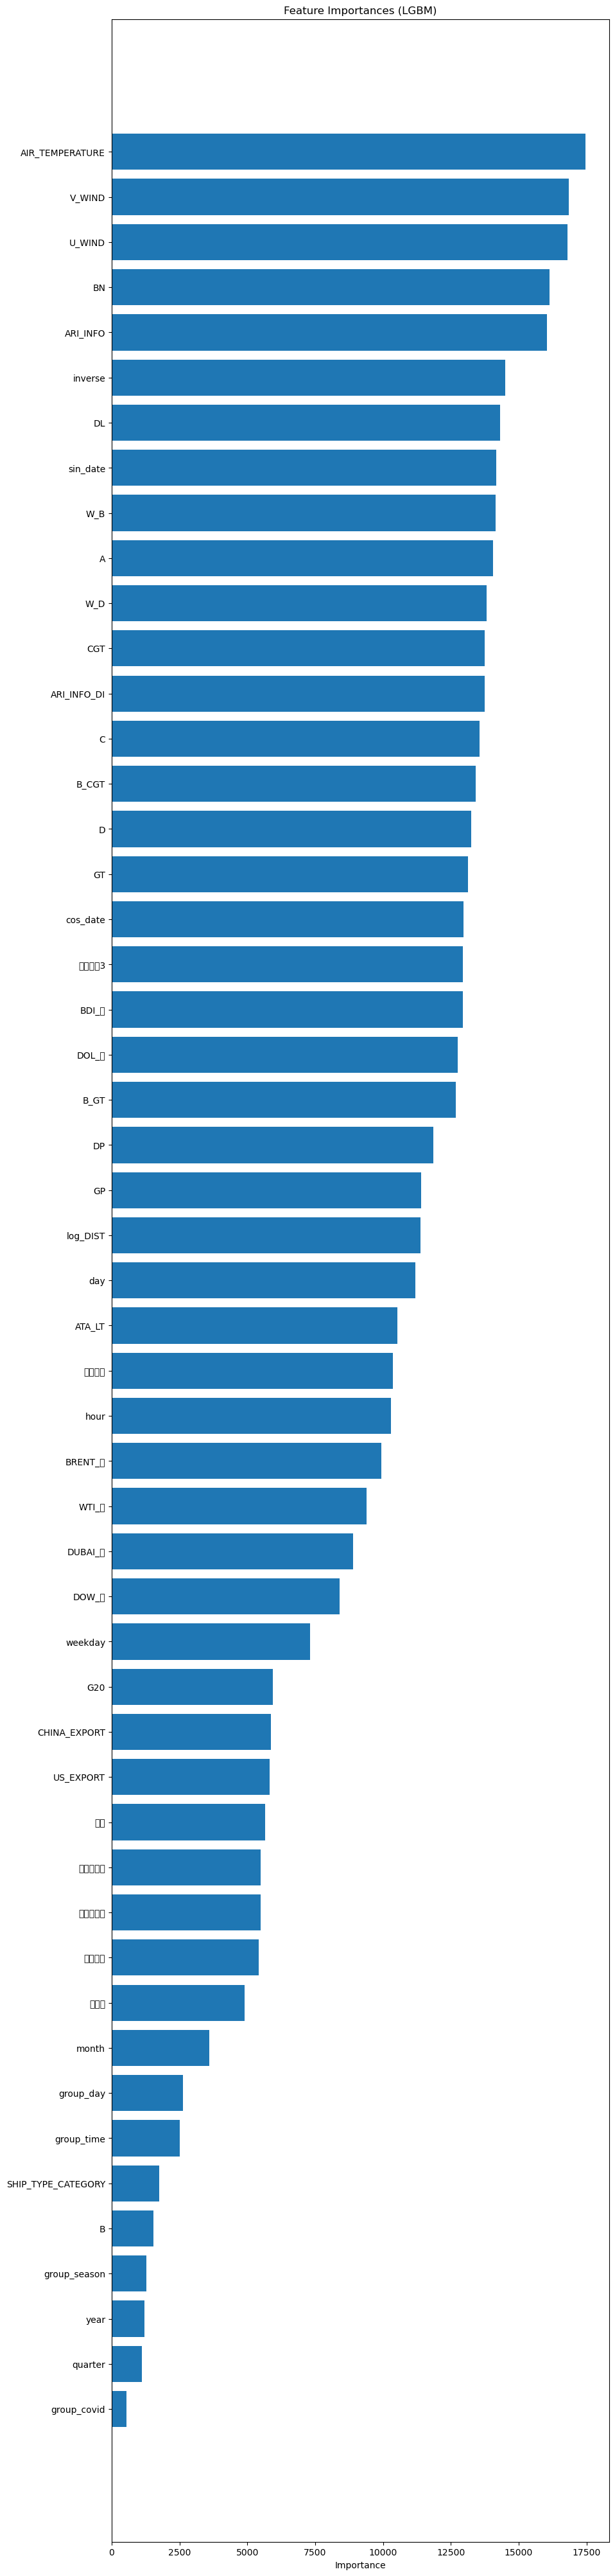

In [65]:
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(
            boosting_type='gbdt',
            num_leaves=100,
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=12,
            subsample=0.7,
            colsample_bytree=0.3,
            random_state=42,
            min_child_samples = 50,
            objective='regression_l1',
            eval_metric='mae'
        ), 'LGBM', train_up_30_select, y_train_up_30_select)

In [66]:
threshold = 500# Your Threshold
low_importance_features = train_up_30_select.columns[lgbm_feature_importances < threshold]

In [67]:
train_1 = train_up_30_select.drop(columns=low_importance_features)
test_1 = test_up_30_select.drop(columns=low_importance_features)
y_train_1 = train_up_30['CI_HOUR'].values

In [68]:
train_1.columns

Index(['GT', 'ATA_LT', 'CGT', 'year', 'month', 'day', 'hour', 'B_GT', 'B_CGT',
       'weekday', 'sin_date', 'cos_date', 'quarter', '접안지', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'BRENT_종', 'inverse', '접안여부', 'DL', 'A', 'B',
       'C', 'DOW_종', 'DOL_종', 'D', 'BDI_종', 'DUBAI_종', 'WTI_종', 'ARI_INFO_DI',
       'GP', 'DP', '접안여부3', 'SHIP_TYPE_CATEGORY', 'ARI_INFO', 'group_covid',
       'group_season', 'group_day', 'group_time', 'log_DIST', 'W_D', 'W_B',
       'CHINA_EXPORT', 'US_EXPORT', '세계교역', '선진국생산', '신흥국생산', 'G20', '미국'],
      dtype='object')

In [69]:
cat_features = ['ARI_INFO_DI','SHIP_TYPE_CATEGORY', 'ARI_INFO',
       'group_season', 'group_day', 'group_time','group_covid']

In [70]:
iterations = 50000
patience = 2000
is_holdout = False


In [71]:
#!pip install xgboost
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# random 26

In [72]:
# import lightgbm as lgb
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_error

# # 경고 끄기
# pd.set_option('mode.chained_assignment', None)
# warnings.filterwarnings(action='ignore')

# models_1 = []
# mae_scores = []
# n_split_list = [10]

# def huber_approx_obj(preds, dtrain):
#     d = dtrain - preds
#     h = 25  # h is delta in the graphic
#     scale = 1 + (d / h) ** 2
#     scale_sqrt = np.sqrt(scale)
#     grad = d / scale_sqrt
#     hess = 1 / scale / scale_sqrt
#     return grad, hess

# for split in n_split_list:
#     fold_idx = 1
#     cv = KFold(n_splits=split, shuffle=True, random_state=26)
#     for train_index, valid_index in cv.split(train_1):
#         X_train, X_valid = train_1.iloc[train_index], train_1.iloc[valid_index]
#         Y_train, Y_valid = y_train_1[train_index], y_train_1[valid_index]
#         #Y_train = np.log1p(Y_train) ; Y_valid = np.log1p(Y_valid)
#         print("=" * 50)

#         model = lgb.LGBMRegressor(
#             boosting_type='gbdt',
#             num_leaves=1500,
#             learning_rate=0.03,
#             n_estimators=iterations,
#             max_depth=12,
#             subsample=0.7,
#             colsample_bytree=0.3,
#             random_state=26,
#             min_child_samples = 50,
#             objective='regression_l1',
#             eval_metric='mae'
#         )
        
# # regression_l1
#         model.fit(
#             X_train, Y_train,
#             eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
#             early_stopping_rounds=patience,
#             verbose=100,categorical_feature=cat_features

#         )

#         pred = model.predict(X_valid)
#         score = mean_absolute_error(Y_valid, pred)
#         print(f"{fold_idx} Fold Validation MAE score: {score}")
#         mae_scores.append(score)
#         models_1.append(model)
#         fold_idx += 1
#         if is_holdout:
#             break

# print("Validation: MAE scores for each fold:", mae_scores)
# print("Validation: MAE:", np.mean(mae_scores))

# random 42

In [78]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 경고 끄기
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')

models_2 = []
mae_scores = []
n_split_list = [10]

def huber_approx_obj(preds, dtrain):
    d = dtrain - preds
    h = 25  # h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

for split in n_split_list:
    fold_idx = 1
    cv = KFold(n_splits=split, shuffle=True, random_state=42)
    for train_index, valid_index in cv.split(train_1):
        X_train, X_valid = train_1.iloc[train_index], train_1.iloc[valid_index]
        Y_train, Y_valid = y_train_1[train_index], y_train_1[valid_index]
        #Y_train = np.log1p(Y_train) ; Y_valid = np.log1p(Y_valid)
        print("=" * 50)

        model = lgb.LGBMRegressor(
            boosting_type='gbdt',
            num_leaves=1500,
            learning_rate=0.03,
            n_estimators=iterations,
            max_depth=12,
            subsample=0.7,
            colsample_bytree=0.3,
            random_state=42,
            min_child_samples = 50,
            objective='regression_l1',
            eval_metric='mae'
        )
        
# regression_l1
        model.fit(
            X_train, Y_train,
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
            early_stopping_rounds=patience,
            verbose=100,categorical_feature=cat_features

        )

        pred = model.predict(X_valid)
        score = mean_absolute_error(Y_valid, pred)
        print(f"{fold_idx} Fold Validation MAE score: {score}")
        mae_scores.append(score)
        models_2.append(model)
        fold_idx += 1
        if is_holdout:
            break

print("Validation: MAE scores for each fold:", mae_scores)
print("Validation: MAE:", np.mean(mae_scores))

[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 2000 rounds
[100]	training's l1: 71.4228	valid_1's l1: 73.3522
[200]	training's l1: 68.9431	valid_1's l1: 72.1928
[300]	training's l1: 67.5485	valid_1's l1: 71.7363
[400]	training's l1: 66.5892	valid_1's l1: 71.4431
[500]	training's l1: 65.7926	valid_1's l1: 71.2351
[600]	training's l1: 65.1397	valid_1's l1: 71.1261
[700]	training's l1: 64.5083	valid_1's l1: 71.0093
[800]	training's l1: 63.9527	valid_1's l1: 70.8641
[900]	training's l1: 63.4517	valid_1's l1: 70.7676
[1000]	training's l1: 62.9775	valid_1's l1: 70.6744
[1100]	training's l1: 62.5351	valid_1's l1: 70.5938
[1200]	training's l1: 62.1725	valid_1's l1: 70.5163
[1300]	training's l1: 61.8086	valid_1's l1: 70.4578
[1400]	training's l1: 61.4963	valid_1's l1: 70.4119
[1500]	training's l1: 61.1979	valid_1's l1: 70.3665
[1600]	training's l1: 60.9158	valid_1's l1: 70.3252
[1700]	training's l1: 60.6421	valid_1's l1: 70.2586
[1800]	tra

[15600]	training's l1: 51.8521	valid_1's l1: 69.5083
[15700]	training's l1: 51.8342	valid_1's l1: 69.507
[15800]	training's l1: 51.8172	valid_1's l1: 69.5047
[15900]	training's l1: 51.8017	valid_1's l1: 69.5041
[16000]	training's l1: 51.7854	valid_1's l1: 69.5037
[16100]	training's l1: 51.7682	valid_1's l1: 69.4992
[16200]	training's l1: 51.7532	valid_1's l1: 69.4987
[16300]	training's l1: 51.7352	valid_1's l1: 69.4969
[16400]	training's l1: 51.7175	valid_1's l1: 69.4922
[16500]	training's l1: 51.6942	valid_1's l1: 69.4836
[16600]	training's l1: 51.6724	valid_1's l1: 69.4847
[16700]	training's l1: 51.6504	valid_1's l1: 69.4828
[16800]	training's l1: 51.631	valid_1's l1: 69.4815
[16900]	training's l1: 51.6105	valid_1's l1: 69.4828
[17000]	training's l1: 51.5915	valid_1's l1: 69.4832
[17100]	training's l1: 51.5719	valid_1's l1: 69.4841
[17200]	training's l1: 51.5531	valid_1's l1: 69.4857
[17300]	training's l1: 51.5329	valid_1's l1: 69.4869
[17400]	training's l1: 51.5096	valid_1's l1: 69.

[31200]	training's l1: 49.7998	valid_1's l1: 69.3813
[31300]	training's l1: 49.7902	valid_1's l1: 69.3813
[31400]	training's l1: 49.779	valid_1's l1: 69.3832
[31500]	training's l1: 49.7708	valid_1's l1: 69.3825
[31600]	training's l1: 49.7592	valid_1's l1: 69.3819
[31700]	training's l1: 49.7513	valid_1's l1: 69.3824
[31800]	training's l1: 49.7428	valid_1's l1: 69.3822
[31900]	training's l1: 49.7341	valid_1's l1: 69.3825
[32000]	training's l1: 49.7252	valid_1's l1: 69.3828
[32100]	training's l1: 49.7166	valid_1's l1: 69.381
[32200]	training's l1: 49.7074	valid_1's l1: 69.3773
[32300]	training's l1: 49.6985	valid_1's l1: 69.3774
[32400]	training's l1: 49.6876	valid_1's l1: 69.3752
[32500]	training's l1: 49.6768	valid_1's l1: 69.3751
[32600]	training's l1: 49.6684	valid_1's l1: 69.3759
[32700]	training's l1: 49.6582	valid_1's l1: 69.3753
[32800]	training's l1: 49.6499	valid_1's l1: 69.3753
[32900]	training's l1: 49.6389	valid_1's l1: 69.3758
[33000]	training's l1: 49.6321	valid_1's l1: 69.

Training until validation scores don't improve for 2000 rounds
[100]	training's l1: 71.2277	valid_1's l1: 74.1534
[200]	training's l1: 68.7362	valid_1's l1: 73.0066
[300]	training's l1: 67.3992	valid_1's l1: 72.598
[400]	training's l1: 66.4496	valid_1's l1: 72.359
[500]	training's l1: 65.648	valid_1's l1: 72.1868
[600]	training's l1: 64.9686	valid_1's l1: 72.0261
[700]	training's l1: 64.3926	valid_1's l1: 71.933
[800]	training's l1: 63.8647	valid_1's l1: 71.8434
[900]	training's l1: 63.4065	valid_1's l1: 71.7627
[1000]	training's l1: 62.9698	valid_1's l1: 71.6999
[1100]	training's l1: 62.5862	valid_1's l1: 71.6427
[1200]	training's l1: 62.1789	valid_1's l1: 71.5757
[1300]	training's l1: 61.8283	valid_1's l1: 71.5203
[1400]	training's l1: 61.4694	valid_1's l1: 71.4803
[1500]	training's l1: 61.1496	valid_1's l1: 71.4377
[1600]	training's l1: 60.885	valid_1's l1: 71.4138
[1700]	training's l1: 60.6214	valid_1's l1: 71.3875
[1800]	training's l1: 60.3431	valid_1's l1: 71.351
[1900]	training'

[15700]	training's l1: 51.7306	valid_1's l1: 70.7467
[15800]	training's l1: 51.7168	valid_1's l1: 70.7469
[15900]	training's l1: 51.7024	valid_1's l1: 70.7451
[16000]	training's l1: 51.6864	valid_1's l1: 70.7462
[16100]	training's l1: 51.6701	valid_1's l1: 70.7477
[16200]	training's l1: 51.6541	valid_1's l1: 70.7483
[16300]	training's l1: 51.6349	valid_1's l1: 70.7471
[16400]	training's l1: 51.6166	valid_1's l1: 70.7485
[16500]	training's l1: 51.5964	valid_1's l1: 70.7484
[16600]	training's l1: 51.575	valid_1's l1: 70.7504
[16700]	training's l1: 51.5556	valid_1's l1: 70.7491
[16800]	training's l1: 51.537	valid_1's l1: 70.7483
[16900]	training's l1: 51.5186	valid_1's l1: 70.7488
[17000]	training's l1: 51.5008	valid_1's l1: 70.7472
[17100]	training's l1: 51.4808	valid_1's l1: 70.7505
[17200]	training's l1: 51.4595	valid_1's l1: 70.7517
[17300]	training's l1: 51.4396	valid_1's l1: 70.7496
[17400]	training's l1: 51.4212	valid_1's l1: 70.7483
[17500]	training's l1: 51.403	valid_1's l1: 70.7

[13100]	training's l1: 52.0546	valid_1's l1: 71.6991
[13200]	training's l1: 52.03	valid_1's l1: 71.6973
[13300]	training's l1: 52.0051	valid_1's l1: 71.6956
[13400]	training's l1: 51.9792	valid_1's l1: 71.6894
[13500]	training's l1: 51.9527	valid_1's l1: 71.6868
[13600]	training's l1: 51.9281	valid_1's l1: 71.6852
[13700]	training's l1: 51.9009	valid_1's l1: 71.6845
[13800]	training's l1: 51.8806	valid_1's l1: 71.6847
[13900]	training's l1: 51.8592	valid_1's l1: 71.6837
[14000]	training's l1: 51.8381	valid_1's l1: 71.6841
[14100]	training's l1: 51.8194	valid_1's l1: 71.6838
[14200]	training's l1: 51.7919	valid_1's l1: 71.6799
[14300]	training's l1: 51.7685	valid_1's l1: 71.6781
[14400]	training's l1: 51.747	valid_1's l1: 71.6783
[14500]	training's l1: 51.7234	valid_1's l1: 71.6739
[14600]	training's l1: 51.7033	valid_1's l1: 71.6726
[14700]	training's l1: 51.6897	valid_1's l1: 71.6715
[14800]	training's l1: 51.6694	valid_1's l1: 71.6736
[14900]	training's l1: 51.6453	valid_1's l1: 71.6

[1700]	training's l1: 60.3117	valid_1's l1: 72.4647
[1800]	training's l1: 60.0444	valid_1's l1: 72.422
[1900]	training's l1: 59.8236	valid_1's l1: 72.3941
[2000]	training's l1: 59.5881	valid_1's l1: 72.3652
[2100]	training's l1: 59.3617	valid_1's l1: 72.3304
[2200]	training's l1: 59.1562	valid_1's l1: 72.3044
[2300]	training's l1: 58.968	valid_1's l1: 72.2792
[2400]	training's l1: 58.8205	valid_1's l1: 72.2657
[2500]	training's l1: 58.6455	valid_1's l1: 72.243
[2600]	training's l1: 58.4797	valid_1's l1: 72.2331
[2700]	training's l1: 58.3159	valid_1's l1: 72.2081
[2800]	training's l1: 58.1604	valid_1's l1: 72.1932
[2900]	training's l1: 58.0118	valid_1's l1: 72.1812
[3000]	training's l1: 57.8672	valid_1's l1: 72.1741
[3100]	training's l1: 57.7284	valid_1's l1: 72.1665
[3200]	training's l1: 57.5855	valid_1's l1: 72.1547
[3300]	training's l1: 57.4489	valid_1's l1: 72.143
[3400]	training's l1: 57.3151	valid_1's l1: 72.1356
[3500]	training's l1: 57.1949	valid_1's l1: 72.1192
[3600]	training'

[17400]	training's l1: 51.0477	valid_1's l1: 71.7818
[17500]	training's l1: 51.0274	valid_1's l1: 71.7827
[17600]	training's l1: 51.0085	valid_1's l1: 71.781
[17700]	training's l1: 50.9917	valid_1's l1: 71.7811
[17800]	training's l1: 50.9769	valid_1's l1: 71.7809
[17900]	training's l1: 50.9611	valid_1's l1: 71.7801
[18000]	training's l1: 50.9452	valid_1's l1: 71.7789
[18100]	training's l1: 50.929	valid_1's l1: 71.7755
[18200]	training's l1: 50.9119	valid_1's l1: 71.7748
[18300]	training's l1: 50.8955	valid_1's l1: 71.7741
[18400]	training's l1: 50.8769	valid_1's l1: 71.7724
[18500]	training's l1: 50.8651	valid_1's l1: 71.7716
[18600]	training's l1: 50.8531	valid_1's l1: 71.7689
[18700]	training's l1: 50.8397	valid_1's l1: 71.7628
[18800]	training's l1: 50.827	valid_1's l1: 71.7627
[18900]	training's l1: 50.8148	valid_1's l1: 71.7618
[19000]	training's l1: 50.8042	valid_1's l1: 71.7608
[19100]	training's l1: 50.7908	valid_1's l1: 71.7608
[19200]	training's l1: 50.7764	valid_1's l1: 71.7

[33000]	training's l1: 49.1312	valid_1's l1: 71.6481
[33100]	training's l1: 49.1227	valid_1's l1: 71.6482
[33200]	training's l1: 49.1156	valid_1's l1: 71.6484
[33300]	training's l1: 49.1068	valid_1's l1: 71.648
[33400]	training's l1: 49.0995	valid_1's l1: 71.6484
[33500]	training's l1: 49.0901	valid_1's l1: 71.6474
[33600]	training's l1: 49.0806	valid_1's l1: 71.6467
[33700]	training's l1: 49.0738	valid_1's l1: 71.6464
[33800]	training's l1: 49.0647	valid_1's l1: 71.6461
[33900]	training's l1: 49.0564	valid_1's l1: 71.646
[34000]	training's l1: 49.0478	valid_1's l1: 71.6462
[34100]	training's l1: 49.0406	valid_1's l1: 71.6466
[34200]	training's l1: 49.0318	valid_1's l1: 71.6455
[34300]	training's l1: 49.0248	valid_1's l1: 71.6456
[34400]	training's l1: 49.0177	valid_1's l1: 71.645
[34500]	training's l1: 49.007	valid_1's l1: 71.6435
[34600]	training's l1: 48.999	valid_1's l1: 71.6435
[34700]	training's l1: 48.9899	valid_1's l1: 71.6426
[34800]	training's l1: 48.9831	valid_1's l1: 71.642

[48600]	training's l1: 48.0647	valid_1's l1: 71.5873
[48700]	training's l1: 48.0587	valid_1's l1: 71.5865
[48800]	training's l1: 48.0539	valid_1's l1: 71.5868
[48900]	training's l1: 48.049	valid_1's l1: 71.5866
[49000]	training's l1: 48.0443	valid_1's l1: 71.5863
[49100]	training's l1: 48.0391	valid_1's l1: 71.5861
[49200]	training's l1: 48.0351	valid_1's l1: 71.586
[49300]	training's l1: 48.0303	valid_1's l1: 71.5865
[49400]	training's l1: 48.0264	valid_1's l1: 71.5868
[49500]	training's l1: 48.0212	valid_1's l1: 71.5864
[49600]	training's l1: 48.0163	valid_1's l1: 71.5853
[49700]	training's l1: 48.0115	valid_1's l1: 71.584
[49800]	training's l1: 48.0059	valid_1's l1: 71.5825
[49900]	training's l1: 48.0006	valid_1's l1: 71.5805
[50000]	training's l1: 47.9959	valid_1's l1: 71.5799
Did not meet early stopping. Best iteration is:
[50000]	training's l1: 47.9959	valid_1's l1: 71.5799
4 Fold Validation MAE score: 71.57986753630824
[LightGBM] [Warning] Unknown parameter: eval_metric
Training

[13800]	training's l1: 52.0332	valid_1's l1: 70.8533
[13900]	training's l1: 52.0031	valid_1's l1: 70.8488
[14000]	training's l1: 51.9798	valid_1's l1: 70.8489
[14100]	training's l1: 51.9565	valid_1's l1: 70.8424
[14200]	training's l1: 51.9353	valid_1's l1: 70.8405
[14300]	training's l1: 51.9149	valid_1's l1: 70.8396
[14400]	training's l1: 51.8911	valid_1's l1: 70.8375
[14500]	training's l1: 51.8661	valid_1's l1: 70.8331
[14600]	training's l1: 51.8364	valid_1's l1: 70.8317
[14700]	training's l1: 51.8075	valid_1's l1: 70.8292
[14800]	training's l1: 51.7843	valid_1's l1: 70.829
[14900]	training's l1: 51.7652	valid_1's l1: 70.8244
[15000]	training's l1: 51.7494	valid_1's l1: 70.8225
[15100]	training's l1: 51.7294	valid_1's l1: 70.8213
[15200]	training's l1: 51.7068	valid_1's l1: 70.8208
[15300]	training's l1: 51.685	valid_1's l1: 70.8194
[15400]	training's l1: 51.6591	valid_1's l1: 70.8147
[15500]	training's l1: 51.6378	valid_1's l1: 70.8138
[15600]	training's l1: 51.6154	valid_1's l1: 70.

[29400]	training's l1: 49.7035	valid_1's l1: 70.7074
[29500]	training's l1: 49.6946	valid_1's l1: 70.7079
[29600]	training's l1: 49.6831	valid_1's l1: 70.7081
[29700]	training's l1: 49.6707	valid_1's l1: 70.7081
[29800]	training's l1: 49.6609	valid_1's l1: 70.7072
[29900]	training's l1: 49.6502	valid_1's l1: 70.7075
[30000]	training's l1: 49.6393	valid_1's l1: 70.7074
[30100]	training's l1: 49.6289	valid_1's l1: 70.7082
[30200]	training's l1: 49.6155	valid_1's l1: 70.7074
[30300]	training's l1: 49.6033	valid_1's l1: 70.7065
[30400]	training's l1: 49.5923	valid_1's l1: 70.704
[30500]	training's l1: 49.5813	valid_1's l1: 70.7029
[30600]	training's l1: 49.5732	valid_1's l1: 70.7032
[30700]	training's l1: 49.5634	valid_1's l1: 70.7024
[30800]	training's l1: 49.5539	valid_1's l1: 70.7025
[30900]	training's l1: 49.543	valid_1's l1: 70.7058
[31000]	training's l1: 49.53	valid_1's l1: 70.704
[31100]	training's l1: 49.5195	valid_1's l1: 70.7032
[31200]	training's l1: 49.5116	valid_1's l1: 70.703

[45000]	training's l1: 48.3714	valid_1's l1: 70.637
[45100]	training's l1: 48.3663	valid_1's l1: 70.6374
[45200]	training's l1: 48.3615	valid_1's l1: 70.6375
[45300]	training's l1: 48.3574	valid_1's l1: 70.6377
[45400]	training's l1: 48.3529	valid_1's l1: 70.6376
[45500]	training's l1: 48.347	valid_1's l1: 70.637
[45600]	training's l1: 48.341	valid_1's l1: 70.6378
[45700]	training's l1: 48.3351	valid_1's l1: 70.6383
[45800]	training's l1: 48.3285	valid_1's l1: 70.6383
[45900]	training's l1: 48.3227	valid_1's l1: 70.6383
[46000]	training's l1: 48.3164	valid_1's l1: 70.6382
[46100]	training's l1: 48.3111	valid_1's l1: 70.6385
[46200]	training's l1: 48.3054	valid_1's l1: 70.6379
[46300]	training's l1: 48.2997	valid_1's l1: 70.6375
[46400]	training's l1: 48.2935	valid_1's l1: 70.6376
[46500]	training's l1: 48.2863	valid_1's l1: 70.6351
[46600]	training's l1: 48.2797	valid_1's l1: 70.6338
[46700]	training's l1: 48.2741	valid_1's l1: 70.6341
[46800]	training's l1: 48.2689	valid_1's l1: 70.63

[1000]	training's l1: 62.9963	valid_1's l1: 71.8773
[1100]	training's l1: 62.5606	valid_1's l1: 71.8152
[1200]	training's l1: 62.1221	valid_1's l1: 71.7532
[1300]	training's l1: 61.7445	valid_1's l1: 71.7
[1400]	training's l1: 61.3722	valid_1's l1: 71.6524
[1500]	training's l1: 61.058	valid_1's l1: 71.6179
[1600]	training's l1: 60.769	valid_1's l1: 71.5862
[1700]	training's l1: 60.4678	valid_1's l1: 71.5454
[1800]	training's l1: 60.2043	valid_1's l1: 71.508
[1900]	training's l1: 59.9675	valid_1's l1: 71.4776
[2000]	training's l1: 59.7324	valid_1's l1: 71.45
[2100]	training's l1: 59.4915	valid_1's l1: 71.4301
[2200]	training's l1: 59.2803	valid_1's l1: 71.4025
[2300]	training's l1: 59.0927	valid_1's l1: 71.3903
[2400]	training's l1: 58.9036	valid_1's l1: 71.3769
[2500]	training's l1: 58.72	valid_1's l1: 71.3603
[2600]	training's l1: 58.5532	valid_1's l1: 71.345
[2700]	training's l1: 58.391	valid_1's l1: 71.3302
[2800]	training's l1: 58.2218	valid_1's l1: 71.319
[2900]	training's l1: 58.

[16800]	training's l1: 51.4234	valid_1's l1: 70.9146
[16900]	training's l1: 51.4057	valid_1's l1: 70.9128
[17000]	training's l1: 51.3884	valid_1's l1: 70.9113
[17100]	training's l1: 51.3719	valid_1's l1: 70.9109
[17200]	training's l1: 51.3545	valid_1's l1: 70.91
[17300]	training's l1: 51.3418	valid_1's l1: 70.9095
[17400]	training's l1: 51.3263	valid_1's l1: 70.9077
[17500]	training's l1: 51.3119	valid_1's l1: 70.9056
[17600]	training's l1: 51.2963	valid_1's l1: 70.9002
[17700]	training's l1: 51.282	valid_1's l1: 70.8998
[17800]	training's l1: 51.2662	valid_1's l1: 70.8992
[17900]	training's l1: 51.2498	valid_1's l1: 70.8987
[18000]	training's l1: 51.2354	valid_1's l1: 70.9
[18100]	training's l1: 51.2212	valid_1's l1: 70.9001
[18200]	training's l1: 51.2033	valid_1's l1: 70.8989
[18300]	training's l1: 51.1869	valid_1's l1: 70.8963
[18400]	training's l1: 51.1713	valid_1's l1: 70.8956
[18500]	training's l1: 51.1528	valid_1's l1: 70.8952
[18600]	training's l1: 51.1356	valid_1's l1: 70.8982

[11600]	training's l1: 52.2309	valid_1's l1: 71.83
[11700]	training's l1: 52.2064	valid_1's l1: 71.8284
[11800]	training's l1: 52.1784	valid_1's l1: 71.8293
[11900]	training's l1: 52.1493	valid_1's l1: 71.8283
[12000]	training's l1: 52.1259	valid_1's l1: 71.8271
[12100]	training's l1: 52.1046	valid_1's l1: 71.8258
[12200]	training's l1: 52.084	valid_1's l1: 71.8243
[12300]	training's l1: 52.0617	valid_1's l1: 71.8243
[12400]	training's l1: 52.0385	valid_1's l1: 71.8217
[12500]	training's l1: 52.0172	valid_1's l1: 71.8216
[12600]	training's l1: 51.9927	valid_1's l1: 71.8197
[12700]	training's l1: 51.9693	valid_1's l1: 71.8204
[12800]	training's l1: 51.9398	valid_1's l1: 71.8162
[12900]	training's l1: 51.9145	valid_1's l1: 71.8171
[13000]	training's l1: 51.8914	valid_1's l1: 71.8182
[13100]	training's l1: 51.8688	valid_1's l1: 71.8165
[13200]	training's l1: 51.8449	valid_1's l1: 71.8189
[13300]	training's l1: 51.8218	valid_1's l1: 71.8168
[13400]	training's l1: 51.8039	valid_1's l1: 71.8

[27200]	training's l1: 49.7379	valid_1's l1: 71.7407
[27300]	training's l1: 49.7247	valid_1's l1: 71.7402
[27400]	training's l1: 49.7117	valid_1's l1: 71.7405
[27500]	training's l1: 49.7022	valid_1's l1: 71.7406
[27600]	training's l1: 49.6915	valid_1's l1: 71.7405
[27700]	training's l1: 49.6808	valid_1's l1: 71.7401
[27800]	training's l1: 49.6697	valid_1's l1: 71.7408
[27900]	training's l1: 49.6557	valid_1's l1: 71.7416
[28000]	training's l1: 49.6404	valid_1's l1: 71.7423
[28100]	training's l1: 49.6269	valid_1's l1: 71.7418
[28200]	training's l1: 49.6175	valid_1's l1: 71.7397
[28300]	training's l1: 49.6087	valid_1's l1: 71.7392
[28400]	training's l1: 49.5986	valid_1's l1: 71.7385
[28500]	training's l1: 49.5894	valid_1's l1: 71.739
[28600]	training's l1: 49.5792	valid_1's l1: 71.7391
[28700]	training's l1: 49.5695	valid_1's l1: 71.7392
[28800]	training's l1: 49.5618	valid_1's l1: 71.739
[28900]	training's l1: 49.5545	valid_1's l1: 71.74
[29000]	training's l1: 49.547	valid_1's l1: 71.739

[42800]	training's l1: 48.442	valid_1's l1: 71.6856
[42900]	training's l1: 48.4338	valid_1's l1: 71.6853
[43000]	training's l1: 48.4257	valid_1's l1: 71.6842
[43100]	training's l1: 48.4193	valid_1's l1: 71.6845
[43200]	training's l1: 48.4137	valid_1's l1: 71.6838
[43300]	training's l1: 48.4082	valid_1's l1: 71.6841
[43400]	training's l1: 48.4015	valid_1's l1: 71.6833
[43500]	training's l1: 48.3959	valid_1's l1: 71.6834
Early stopping, best iteration is:
[41549]	training's l1: 48.5229	valid_1's l1: 71.682
8 Fold Validation MAE score: 71.68195417633326
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 2000 rounds
[100]	training's l1: 71.3338	valid_1's l1: 74.2328
[200]	training's l1: 68.7963	valid_1's l1: 73.0931
[300]	training's l1: 67.4349	valid_1's l1: 72.6804
[400]	training's l1: 66.4559	valid_1's l1: 72.4333
[500]	training's l1: 65.696	valid_1's l1: 72.2575
[600]	training's l1: 65.0131	valid_1's l1: 72.0955
[700]	training's l1: 64

[14500]	training's l1: 51.857	valid_1's l1: 70.6568
[14600]	training's l1: 51.8369	valid_1's l1: 70.6559
[14700]	training's l1: 51.8165	valid_1's l1: 70.6548
[14800]	training's l1: 51.7977	valid_1's l1: 70.6534
[14900]	training's l1: 51.7761	valid_1's l1: 70.6516
[15000]	training's l1: 51.7574	valid_1's l1: 70.6529
[15100]	training's l1: 51.7396	valid_1's l1: 70.6517
[15200]	training's l1: 51.7225	valid_1's l1: 70.6489
[15300]	training's l1: 51.7026	valid_1's l1: 70.6472
[15400]	training's l1: 51.683	valid_1's l1: 70.6446
[15500]	training's l1: 51.6642	valid_1's l1: 70.644
[15600]	training's l1: 51.6495	valid_1's l1: 70.6434
[15700]	training's l1: 51.634	valid_1's l1: 70.643
[15800]	training's l1: 51.6176	valid_1's l1: 70.6431
[15900]	training's l1: 51.6004	valid_1's l1: 70.6382
[16000]	training's l1: 51.5803	valid_1's l1: 70.6348
[16100]	training's l1: 51.5554	valid_1's l1: 70.6251
[16200]	training's l1: 51.5385	valid_1's l1: 70.6247
[16300]	training's l1: 51.5196	valid_1's l1: 70.623

[30100]	training's l1: 49.6711	valid_1's l1: 70.5431
[30200]	training's l1: 49.6602	valid_1's l1: 70.5428
[30300]	training's l1: 49.651	valid_1's l1: 70.5429
[30400]	training's l1: 49.641	valid_1's l1: 70.5435
[30500]	training's l1: 49.6275	valid_1's l1: 70.5404
[30600]	training's l1: 49.6183	valid_1's l1: 70.5395
[30700]	training's l1: 49.6096	valid_1's l1: 70.5378
[30800]	training's l1: 49.6003	valid_1's l1: 70.5382
[30900]	training's l1: 49.5905	valid_1's l1: 70.5378
[31000]	training's l1: 49.5805	valid_1's l1: 70.5382
[31100]	training's l1: 49.5723	valid_1's l1: 70.5386
[31200]	training's l1: 49.5638	valid_1's l1: 70.539
[31300]	training's l1: 49.5528	valid_1's l1: 70.5399
[31400]	training's l1: 49.5397	valid_1's l1: 70.538
[31500]	training's l1: 49.5311	valid_1's l1: 70.5383
[31600]	training's l1: 49.5202	valid_1's l1: 70.5374
[31700]	training's l1: 49.5107	valid_1's l1: 70.5375
[31800]	training's l1: 49.5016	valid_1's l1: 70.5382
[31900]	training's l1: 49.4914	valid_1's l1: 70.53

[45700]	training's l1: 48.4831	valid_1's l1: 70.5028
[45800]	training's l1: 48.4769	valid_1's l1: 70.5015
[45900]	training's l1: 48.4717	valid_1's l1: 70.5016
[46000]	training's l1: 48.4644	valid_1's l1: 70.4998
[46100]	training's l1: 48.459	valid_1's l1: 70.5
[46200]	training's l1: 48.4532	valid_1's l1: 70.4999
[46300]	training's l1: 48.4475	valid_1's l1: 70.4993
[46400]	training's l1: 48.4414	valid_1's l1: 70.4986
[46500]	training's l1: 48.4354	valid_1's l1: 70.4981
[46600]	training's l1: 48.429	valid_1's l1: 70.4982
[46700]	training's l1: 48.4228	valid_1's l1: 70.4973
[46800]	training's l1: 48.4174	valid_1's l1: 70.4968
[46900]	training's l1: 48.4118	valid_1's l1: 70.4965
[47000]	training's l1: 48.4062	valid_1's l1: 70.4957
[47100]	training's l1: 48.4008	valid_1's l1: 70.4958
[47200]	training's l1: 48.3947	valid_1's l1: 70.4956
[47300]	training's l1: 48.3887	valid_1's l1: 70.4949
[47400]	training's l1: 48.3809	valid_1's l1: 70.4955
[47500]	training's l1: 48.374	valid_1's l1: 70.4956

[10900]	training's l1: 52.6925	valid_1's l1: 70.8453
[11000]	training's l1: 52.6554	valid_1's l1: 70.8433
[11100]	training's l1: 52.6257	valid_1's l1: 70.8399
[11200]	training's l1: 52.5992	valid_1's l1: 70.8375
[11300]	training's l1: 52.5768	valid_1's l1: 70.8355
[11400]	training's l1: 52.5527	valid_1's l1: 70.8345
[11500]	training's l1: 52.5268	valid_1's l1: 70.832
[11600]	training's l1: 52.4985	valid_1's l1: 70.8298
[11700]	training's l1: 52.4615	valid_1's l1: 70.8281
[11800]	training's l1: 52.4336	valid_1's l1: 70.8269
[11900]	training's l1: 52.411	valid_1's l1: 70.8234
[12000]	training's l1: 52.3834	valid_1's l1: 70.821
[12100]	training's l1: 52.3528	valid_1's l1: 70.8205
[12200]	training's l1: 52.3196	valid_1's l1: 70.8189
[12300]	training's l1: 52.2857	valid_1's l1: 70.819
[12400]	training's l1: 52.2577	valid_1's l1: 70.8161
[12500]	training's l1: 52.233	valid_1's l1: 70.8149
[12600]	training's l1: 52.2111	valid_1's l1: 70.8153
[12700]	training's l1: 52.188	valid_1's l1: 70.813


[26500]	training's l1: 50.0424	valid_1's l1: 70.6968
[26600]	training's l1: 50.0321	valid_1's l1: 70.6959
[26700]	training's l1: 50.0222	valid_1's l1: 70.6964
[26800]	training's l1: 50.011	valid_1's l1: 70.6953
[26900]	training's l1: 50.0024	valid_1's l1: 70.6953
[27000]	training's l1: 49.9909	valid_1's l1: 70.6946
[27100]	training's l1: 49.9755	valid_1's l1: 70.6926
[27200]	training's l1: 49.9599	valid_1's l1: 70.6908
[27300]	training's l1: 49.9438	valid_1's l1: 70.6923
[27400]	training's l1: 49.9299	valid_1's l1: 70.6926
[27500]	training's l1: 49.9185	valid_1's l1: 70.6911
[27600]	training's l1: 49.9066	valid_1's l1: 70.6897
[27700]	training's l1: 49.8907	valid_1's l1: 70.6854
[27800]	training's l1: 49.8754	valid_1's l1: 70.6832
[27900]	training's l1: 49.8581	valid_1's l1: 70.683
[28000]	training's l1: 49.8432	valid_1's l1: 70.6813
[28100]	training's l1: 49.8292	valid_1's l1: 70.6798
[28200]	training's l1: 49.8142	valid_1's l1: 70.6781
[28300]	training's l1: 49.801	valid_1's l1: 70.6

# random 69

In [77]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 경고 끄기
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings(action='ignore')

models_3 = []
mae_scores = []
n_split_list = [10]

def huber_approx_obj(preds, dtrain):
    d = dtrain - preds
    h = 25  # h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

for split in n_split_list:
    fold_idx = 1
    cv = KFold(n_splits=split, shuffle=True, random_state=69)
    for train_index, valid_index in cv.split(train_1):
        X_train, X_valid = train_1.iloc[train_index], train_1.iloc[valid_index]
        Y_train, Y_valid = y_train_1[train_index], y_train_1[valid_index]
        #Y_train = np.log1p(Y_train) ; Y_valid = np.log1p(Y_valid)
        print("=" * 50)

        model = lgb.LGBMRegressor(
            boosting_type='gbdt',
            num_leaves=1500,
            learning_rate=0.03,
            n_estimators=iterations,
            max_depth=12,
            subsample=0.7,
            colsample_bytree=0.3,
            random_state=69,
            min_child_samples = 50,
            objective='regression_l1',
            eval_metric='mae'
        )
        
# regression_l1
        model.fit(
            X_train, Y_train,
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
            early_stopping_rounds=patience,
            verbose=100,categorical_feature=cat_features

        )

        pred = model.predict(X_valid)
        score = mean_absolute_error(Y_valid, pred)
        print(f"{fold_idx} Fold Validation MAE score: {score}")
        mae_scores.append(score)
        models_3.append(model)
        fold_idx += 1
        if is_holdout:
            break

print("Validation: MAE scores for each fold:", mae_scores)
print("Validation: MAE:", np.mean(mae_scores))

Training until validation scores don't improve for 2000 rounds
[100]	training's l1: 71.4077	valid_1's l1: 74.5228
[200]	training's l1: 68.9045	valid_1's l1: 73.2896
[300]	training's l1: 67.5507	valid_1's l1: 72.8373
[400]	training's l1: 66.6468	valid_1's l1: 72.5834
[500]	training's l1: 65.8738	valid_1's l1: 72.36
[600]	training's l1: 65.1845	valid_1's l1: 72.2033
[700]	training's l1: 64.5754	valid_1's l1: 72.0497
[800]	training's l1: 63.9998	valid_1's l1: 71.9282
[900]	training's l1: 63.5206	valid_1's l1: 71.8281
[1000]	training's l1: 63.0764	valid_1's l1: 71.7464
[1100]	training's l1: 62.6415	valid_1's l1: 71.6638
[1200]	training's l1: 62.2208	valid_1's l1: 71.5832
[1300]	training's l1: 61.8693	valid_1's l1: 71.5308
[1400]	training's l1: 61.5067	valid_1's l1: 71.4514
[1500]	training's l1: 61.1859	valid_1's l1: 71.3993
[1600]	training's l1: 60.8681	valid_1's l1: 71.3544
[1700]	training's l1: 60.5921	valid_1's l1: 71.3189
[1800]	training's l1: 60.3455	valid_1's l1: 71.2876
[1900]	train

[15700]	training's l1: 51.5907	valid_1's l1: 70.5328
[15800]	training's l1: 51.5648	valid_1's l1: 70.5304
[15900]	training's l1: 51.5394	valid_1's l1: 70.5302
[16000]	training's l1: 51.5159	valid_1's l1: 70.5258
[16100]	training's l1: 51.4942	valid_1's l1: 70.523
[16200]	training's l1: 51.476	valid_1's l1: 70.5213
[16300]	training's l1: 51.4542	valid_1's l1: 70.5179
[16400]	training's l1: 51.4372	valid_1's l1: 70.5176
[16500]	training's l1: 51.4179	valid_1's l1: 70.5169
[16600]	training's l1: 51.4028	valid_1's l1: 70.5168
[16700]	training's l1: 51.3877	valid_1's l1: 70.5146
[16800]	training's l1: 51.3704	valid_1's l1: 70.515
[16900]	training's l1: 51.3558	valid_1's l1: 70.5137
[17000]	training's l1: 51.3407	valid_1's l1: 70.5146
[17100]	training's l1: 51.3249	valid_1's l1: 70.5145
[17200]	training's l1: 51.3098	valid_1's l1: 70.5124
[17300]	training's l1: 51.2932	valid_1's l1: 70.5127
[17400]	training's l1: 51.2776	valid_1's l1: 70.5104
[17500]	training's l1: 51.2565	valid_1's l1: 70.5

[4200]	training's l1: 56.872	valid_1's l1: 70.3279
[4300]	training's l1: 56.7774	valid_1's l1: 70.3193
[4400]	training's l1: 56.6794	valid_1's l1: 70.3077
[4500]	training's l1: 56.5831	valid_1's l1: 70.2963
[4600]	training's l1: 56.4865	valid_1's l1: 70.2925
[4700]	training's l1: 56.3742	valid_1's l1: 70.2834
[4800]	training's l1: 56.2676	valid_1's l1: 70.2735
[4900]	training's l1: 56.1888	valid_1's l1: 70.2694
[5000]	training's l1: 56.1076	valid_1's l1: 70.2637
[5100]	training's l1: 56.027	valid_1's l1: 70.2549
[5200]	training's l1: 55.9395	valid_1's l1: 70.2452
[5300]	training's l1: 55.8549	valid_1's l1: 70.2442
[5400]	training's l1: 55.7672	valid_1's l1: 70.2343
[5500]	training's l1: 55.6936	valid_1's l1: 70.2298
[5600]	training's l1: 55.6172	valid_1's l1: 70.2263
[5700]	training's l1: 55.54	valid_1's l1: 70.2212
[5800]	training's l1: 55.4759	valid_1's l1: 70.2179
[5900]	training's l1: 55.41	valid_1's l1: 70.2154
[6000]	training's l1: 55.3336	valid_1's l1: 70.2172
[6100]	training's 

[19900]	training's l1: 51.2175	valid_1's l1: 70.0837
[20000]	training's l1: 51.2017	valid_1's l1: 70.0838
[20100]	training's l1: 51.1877	valid_1's l1: 70.0843
[20200]	training's l1: 51.1691	valid_1's l1: 70.0819
[20300]	training's l1: 51.1532	valid_1's l1: 70.0833
[20400]	training's l1: 51.1371	valid_1's l1: 70.0832
[20500]	training's l1: 51.121	valid_1's l1: 70.0845
[20600]	training's l1: 51.1059	valid_1's l1: 70.0843
[20700]	training's l1: 51.0887	valid_1's l1: 70.0838
[20800]	training's l1: 51.0741	valid_1's l1: 70.0844
[20900]	training's l1: 51.0597	valid_1's l1: 70.0842
[21000]	training's l1: 51.0423	valid_1's l1: 70.0819
[21100]	training's l1: 51.0259	valid_1's l1: 70.0809
[21200]	training's l1: 51.01	valid_1's l1: 70.0837
[21300]	training's l1: 50.9943	valid_1's l1: 70.0824
Early stopping, best iteration is:
[19328]	training's l1: 51.2931	valid_1's l1: 70.0797
2 Fold Validation MAE score: 70.0797062958349
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validat

[13800]	training's l1: 52.0742	valid_1's l1: 69.8336
[13900]	training's l1: 52.0595	valid_1's l1: 69.8323
[14000]	training's l1: 52.0393	valid_1's l1: 69.8325
[14100]	training's l1: 52.0218	valid_1's l1: 69.8305
[14200]	training's l1: 52.0038	valid_1's l1: 69.8292
[14300]	training's l1: 51.9803	valid_1's l1: 69.8276
[14400]	training's l1: 51.9591	valid_1's l1: 69.8243
[14500]	training's l1: 51.9385	valid_1's l1: 69.8231
[14600]	training's l1: 51.9185	valid_1's l1: 69.8199
[14700]	training's l1: 51.9011	valid_1's l1: 69.8181
[14800]	training's l1: 51.884	valid_1's l1: 69.8174
[14900]	training's l1: 51.8586	valid_1's l1: 69.8139
[15000]	training's l1: 51.8361	valid_1's l1: 69.8108
[15100]	training's l1: 51.8154	valid_1's l1: 69.8087
[15200]	training's l1: 51.7999	valid_1's l1: 69.8086
[15300]	training's l1: 51.786	valid_1's l1: 69.8077
[15400]	training's l1: 51.769	valid_1's l1: 69.8071
[15500]	training's l1: 51.7466	valid_1's l1: 69.8078
[15600]	training's l1: 51.7263	valid_1's l1: 69.8

[29400]	training's l1: 49.8888	valid_1's l1: 69.6804
[29500]	training's l1: 49.8776	valid_1's l1: 69.6769
[29600]	training's l1: 49.8677	valid_1's l1: 69.6772
[29700]	training's l1: 49.8556	valid_1's l1: 69.6748
[29800]	training's l1: 49.845	valid_1's l1: 69.674
[29900]	training's l1: 49.8329	valid_1's l1: 69.6743
[30000]	training's l1: 49.8199	valid_1's l1: 69.6724
[30100]	training's l1: 49.8089	valid_1's l1: 69.6724
[30200]	training's l1: 49.7966	valid_1's l1: 69.6716
[30300]	training's l1: 49.7854	valid_1's l1: 69.6722
[30400]	training's l1: 49.7727	valid_1's l1: 69.6672
[30500]	training's l1: 49.7626	valid_1's l1: 69.6669
[30600]	training's l1: 49.7527	valid_1's l1: 69.6661
[30700]	training's l1: 49.7386	valid_1's l1: 69.6626
[30800]	training's l1: 49.7282	valid_1's l1: 69.6616
[30900]	training's l1: 49.719	valid_1's l1: 69.6617
[31000]	training's l1: 49.7087	valid_1's l1: 69.6613
[31100]	training's l1: 49.6973	valid_1's l1: 69.6608
[31200]	training's l1: 49.6856	valid_1's l1: 69.6

[45000]	training's l1: 48.5182	valid_1's l1: 69.5759
[45100]	training's l1: 48.5087	valid_1's l1: 69.5761
[45200]	training's l1: 48.4961	valid_1's l1: 69.5757
[45300]	training's l1: 48.4834	valid_1's l1: 69.5755
[45400]	training's l1: 48.4732	valid_1's l1: 69.5742
[45500]	training's l1: 48.4666	valid_1's l1: 69.5742
[45600]	training's l1: 48.4599	valid_1's l1: 69.5737
[45700]	training's l1: 48.4525	valid_1's l1: 69.5732
[45800]	training's l1: 48.4448	valid_1's l1: 69.5726
[45900]	training's l1: 48.4368	valid_1's l1: 69.5731
[46000]	training's l1: 48.4302	valid_1's l1: 69.5728
[46100]	training's l1: 48.4231	valid_1's l1: 69.5724
[46200]	training's l1: 48.4176	valid_1's l1: 69.5715
[46300]	training's l1: 48.4131	valid_1's l1: 69.5715
[46400]	training's l1: 48.4085	valid_1's l1: 69.5717
[46500]	training's l1: 48.4026	valid_1's l1: 69.5713
[46600]	training's l1: 48.3959	valid_1's l1: 69.5714
[46700]	training's l1: 48.3874	valid_1's l1: 69.5685
[46800]	training's l1: 48.3816	valid_1's l1: 6

[10200]	training's l1: 52.9194	valid_1's l1: 72.6513
[10300]	training's l1: 52.8928	valid_1's l1: 72.6449
[10400]	training's l1: 52.8712	valid_1's l1: 72.6461
[10500]	training's l1: 52.8424	valid_1's l1: 72.6481
[10600]	training's l1: 52.8091	valid_1's l1: 72.6454
[10700]	training's l1: 52.7735	valid_1's l1: 72.6454
[10800]	training's l1: 52.7439	valid_1's l1: 72.6451
[10900]	training's l1: 52.7071	valid_1's l1: 72.6462
[11000]	training's l1: 52.6743	valid_1's l1: 72.6458
[11100]	training's l1: 52.6471	valid_1's l1: 72.645
[11200]	training's l1: 52.6177	valid_1's l1: 72.6441
[11300]	training's l1: 52.5908	valid_1's l1: 72.6458
[11400]	training's l1: 52.5657	valid_1's l1: 72.6463
[11500]	training's l1: 52.5364	valid_1's l1: 72.645
[11600]	training's l1: 52.5096	valid_1's l1: 72.6453
[11700]	training's l1: 52.484	valid_1's l1: 72.6449
[11800]	training's l1: 52.4611	valid_1's l1: 72.6463
[11900]	training's l1: 52.4369	valid_1's l1: 72.6455
[12000]	training's l1: 52.4113	valid_1's l1: 72.6

[12800]	training's l1: 52.3721	valid_1's l1: 70.3516
[12900]	training's l1: 52.3508	valid_1's l1: 70.3513
[13000]	training's l1: 52.3242	valid_1's l1: 70.3513
[13100]	training's l1: 52.2993	valid_1's l1: 70.3501
[13200]	training's l1: 52.2726	valid_1's l1: 70.3455
[13300]	training's l1: 52.2476	valid_1's l1: 70.3447
[13400]	training's l1: 52.2176	valid_1's l1: 70.3437
[13500]	training's l1: 52.1931	valid_1's l1: 70.3442
[13600]	training's l1: 52.168	valid_1's l1: 70.3428
[13700]	training's l1: 52.1416	valid_1's l1: 70.3394
[13800]	training's l1: 52.1179	valid_1's l1: 70.3359
[13900]	training's l1: 52.0937	valid_1's l1: 70.3333
[14000]	training's l1: 52.0716	valid_1's l1: 70.3323
[14100]	training's l1: 52.0491	valid_1's l1: 70.332
[14200]	training's l1: 52.0307	valid_1's l1: 70.3316
[14300]	training's l1: 52.0112	valid_1's l1: 70.3323
[14400]	training's l1: 51.9927	valid_1's l1: 70.3302
[14500]	training's l1: 51.9728	valid_1's l1: 70.3306
[14600]	training's l1: 51.9557	valid_1's l1: 70.

[28400]	training's l1: 49.9117	valid_1's l1: 70.2349
[28500]	training's l1: 49.8989	valid_1's l1: 70.2352
[28600]	training's l1: 49.8859	valid_1's l1: 70.2361
[28700]	training's l1: 49.8751	valid_1's l1: 70.2337
[28800]	training's l1: 49.8647	valid_1's l1: 70.231
[28900]	training's l1: 49.852	valid_1's l1: 70.2294
[29000]	training's l1: 49.8431	valid_1's l1: 70.2291
[29100]	training's l1: 49.8338	valid_1's l1: 70.2294
[29200]	training's l1: 49.8249	valid_1's l1: 70.2278
[29300]	training's l1: 49.8148	valid_1's l1: 70.2272
[29400]	training's l1: 49.8061	valid_1's l1: 70.2282
[29500]	training's l1: 49.7981	valid_1's l1: 70.227
[29600]	training's l1: 49.7879	valid_1's l1: 70.2263
[29700]	training's l1: 49.7759	valid_1's l1: 70.2267
[29800]	training's l1: 49.765	valid_1's l1: 70.227
[29900]	training's l1: 49.7539	valid_1's l1: 70.2267
[30000]	training's l1: 49.7429	valid_1's l1: 70.2259
[30100]	training's l1: 49.735	valid_1's l1: 70.2262
[30200]	training's l1: 49.7244	valid_1's l1: 70.226


[44000]	training's l1: 48.5013	valid_1's l1: 70.1803
[44100]	training's l1: 48.4959	valid_1's l1: 70.1805
[44200]	training's l1: 48.49	valid_1's l1: 70.1807
[44300]	training's l1: 48.4843	valid_1's l1: 70.1805
[44400]	training's l1: 48.4792	valid_1's l1: 70.1805
[44500]	training's l1: 48.4742	valid_1's l1: 70.1805
[44600]	training's l1: 48.4698	valid_1's l1: 70.1803
[44700]	training's l1: 48.4637	valid_1's l1: 70.1796
[44800]	training's l1: 48.4562	valid_1's l1: 70.1775
[44900]	training's l1: 48.4507	valid_1's l1: 70.1772
[45000]	training's l1: 48.4448	valid_1's l1: 70.177
[45100]	training's l1: 48.4402	valid_1's l1: 70.1773
[45200]	training's l1: 48.4333	valid_1's l1: 70.1771
[45300]	training's l1: 48.4283	valid_1's l1: 70.1769
[45400]	training's l1: 48.4234	valid_1's l1: 70.1767
[45500]	training's l1: 48.4195	valid_1's l1: 70.1769
[45600]	training's l1: 48.414	valid_1's l1: 70.177
[45700]	training's l1: 48.409	valid_1's l1: 70.1767
[45800]	training's l1: 48.4039	valid_1's l1: 70.1769

[9200]	training's l1: 53.243	valid_1's l1: 72.1644
[9300]	training's l1: 53.2043	valid_1's l1: 72.1661
[9400]	training's l1: 53.1622	valid_1's l1: 72.1648
[9500]	training's l1: 53.1305	valid_1's l1: 72.1652
[9600]	training's l1: 53.0937	valid_1's l1: 72.1617
[9700]	training's l1: 53.05	valid_1's l1: 72.1586
[9800]	training's l1: 53.0176	valid_1's l1: 72.1562
[9900]	training's l1: 52.9847	valid_1's l1: 72.1546
[10000]	training's l1: 52.9493	valid_1's l1: 72.1508
[10100]	training's l1: 52.9149	valid_1's l1: 72.1499
[10200]	training's l1: 52.8863	valid_1's l1: 72.1488
[10300]	training's l1: 52.8591	valid_1's l1: 72.1466
[10400]	training's l1: 52.8335	valid_1's l1: 72.1454
[10500]	training's l1: 52.8113	valid_1's l1: 72.1447
[10600]	training's l1: 52.7775	valid_1's l1: 72.1412
[10700]	training's l1: 52.7469	valid_1's l1: 72.1392
[10800]	training's l1: 52.7185	valid_1's l1: 72.1364
[10900]	training's l1: 52.6943	valid_1's l1: 72.136
[11000]	training's l1: 52.6648	valid_1's l1: 72.1361
[1110

[24800]	training's l1: 50.083	valid_1's l1: 72.0397
[24900]	training's l1: 50.0708	valid_1's l1: 72.0409
[25000]	training's l1: 50.0602	valid_1's l1: 72.0413
[25100]	training's l1: 50.0499	valid_1's l1: 72.041
[25200]	training's l1: 50.0383	valid_1's l1: 72.0406
[25300]	training's l1: 50.0253	valid_1's l1: 72.0403
[25400]	training's l1: 50.014	valid_1's l1: 72.0396
[25500]	training's l1: 50.0001	valid_1's l1: 72.0417
[25600]	training's l1: 49.9845	valid_1's l1: 72.0519
[25700]	training's l1: 49.9717	valid_1's l1: 72.0527
[25800]	training's l1: 49.9566	valid_1's l1: 72.0523
[25900]	training's l1: 49.9435	valid_1's l1: 72.052
Early stopping, best iteration is:
[23968]	training's l1: 50.1852	valid_1's l1: 72.0382
6 Fold Validation MAE score: 72.03820017291007
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 2000 rounds
[100]	training's l1: 71.2768	valid_1's l1: 75.4294
[200]	training's l1: 68.7163	valid_1's l1: 74.2336
[300]	training's

[14100]	training's l1: 51.8914	valid_1's l1: 71.918
[14200]	training's l1: 51.8695	valid_1's l1: 71.916
[14300]	training's l1: 51.8482	valid_1's l1: 71.9145
[14400]	training's l1: 51.8298	valid_1's l1: 71.9137
[14500]	training's l1: 51.8083	valid_1's l1: 71.9133
[14600]	training's l1: 51.7904	valid_1's l1: 71.9134
[14700]	training's l1: 51.7729	valid_1's l1: 71.9136
[14800]	training's l1: 51.7568	valid_1's l1: 71.9144
[14900]	training's l1: 51.7408	valid_1's l1: 71.9131
[15000]	training's l1: 51.721	valid_1's l1: 71.9138
[15100]	training's l1: 51.701	valid_1's l1: 71.9144
[15200]	training's l1: 51.6848	valid_1's l1: 71.912
[15300]	training's l1: 51.6686	valid_1's l1: 71.9098
[15400]	training's l1: 51.6533	valid_1's l1: 71.9087
[15500]	training's l1: 51.6401	valid_1's l1: 71.9089
[15600]	training's l1: 51.6264	valid_1's l1: 71.9089
[15700]	training's l1: 51.6105	valid_1's l1: 71.9084
[15800]	training's l1: 51.5956	valid_1's l1: 71.9072
[15900]	training's l1: 51.5803	valid_1's l1: 71.906

[29700]	training's l1: 49.7669	valid_1's l1: 71.8093
[29800]	training's l1: 49.7564	valid_1's l1: 71.8089
[29900]	training's l1: 49.7456	valid_1's l1: 71.8098
[30000]	training's l1: 49.7373	valid_1's l1: 71.8092
[30100]	training's l1: 49.7279	valid_1's l1: 71.8077
[30200]	training's l1: 49.7184	valid_1's l1: 71.8054
[30300]	training's l1: 49.7091	valid_1's l1: 71.8037
[30400]	training's l1: 49.6991	valid_1's l1: 71.8044
[30500]	training's l1: 49.6874	valid_1's l1: 71.8023
[30600]	training's l1: 49.6784	valid_1's l1: 71.8018
[30700]	training's l1: 49.6677	valid_1's l1: 71.8014
[30800]	training's l1: 49.6562	valid_1's l1: 71.7994
[30900]	training's l1: 49.6469	valid_1's l1: 71.7988
[31000]	training's l1: 49.6378	valid_1's l1: 71.7976
[31100]	training's l1: 49.6271	valid_1's l1: 71.7948
[31200]	training's l1: 49.6154	valid_1's l1: 71.7951
[31300]	training's l1: 49.606	valid_1's l1: 71.7936
[31400]	training's l1: 49.5962	valid_1's l1: 71.7914
[31500]	training's l1: 49.5855	valid_1's l1: 71

[45300]	training's l1: 48.4566	valid_1's l1: 71.7107
[45400]	training's l1: 48.4489	valid_1's l1: 71.7103
[45500]	training's l1: 48.4422	valid_1's l1: 71.7109
[45600]	training's l1: 48.432	valid_1's l1: 71.7128
[45700]	training's l1: 48.425	valid_1's l1: 71.7118
[45800]	training's l1: 48.4178	valid_1's l1: 71.7103
Early stopping, best iteration is:
[43806]	training's l1: 48.5662	valid_1's l1: 71.7064
7 Fold Validation MAE score: 71.70635276398312
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 2000 rounds
[100]	training's l1: 71.4385	valid_1's l1: 74.714
[200]	training's l1: 68.886	valid_1's l1: 73.3922
[300]	training's l1: 67.513	valid_1's l1: 72.8764
[400]	training's l1: 66.4651	valid_1's l1: 72.5937
[500]	training's l1: 65.6532	valid_1's l1: 72.3935
[600]	training's l1: 64.961	valid_1's l1: 72.2546
[700]	training's l1: 64.3536	valid_1's l1: 72.1665
[800]	training's l1: 63.8501	valid_1's l1: 72.0783
[900]	training's l1: 63.3769	v

[14700]	training's l1: 51.9312	valid_1's l1: 71.0726
[14800]	training's l1: 51.9112	valid_1's l1: 71.0736
[14900]	training's l1: 51.8928	valid_1's l1: 71.0707
[15000]	training's l1: 51.8746	valid_1's l1: 71.0687
[15100]	training's l1: 51.8552	valid_1's l1: 71.0672
[15200]	training's l1: 51.8344	valid_1's l1: 71.0663
[15300]	training's l1: 51.8183	valid_1's l1: 71.0648
[15400]	training's l1: 51.8008	valid_1's l1: 71.0644
[15500]	training's l1: 51.7818	valid_1's l1: 71.0637
[15600]	training's l1: 51.7653	valid_1's l1: 71.063
[15700]	training's l1: 51.7404	valid_1's l1: 71.0613
[15800]	training's l1: 51.7139	valid_1's l1: 71.0562
[15900]	training's l1: 51.6926	valid_1's l1: 71.0568
[16000]	training's l1: 51.6694	valid_1's l1: 71.0512
[16100]	training's l1: 51.6512	valid_1's l1: 71.0484
[16200]	training's l1: 51.6374	valid_1's l1: 71.0477
[16300]	training's l1: 51.6195	valid_1's l1: 71.0459
[16400]	training's l1: 51.5998	valid_1's l1: 71.0449
[16500]	training's l1: 51.581	valid_1's l1: 71.

[400]	training's l1: 66.4663	valid_1's l1: 72.5201
[500]	training's l1: 65.6486	valid_1's l1: 72.3369
[600]	training's l1: 64.989	valid_1's l1: 72.2132
[700]	training's l1: 64.4098	valid_1's l1: 72.078
[800]	training's l1: 63.9433	valid_1's l1: 72.0034
[900]	training's l1: 63.4567	valid_1's l1: 71.9286
[1000]	training's l1: 63.0306	valid_1's l1: 71.8698
[1100]	training's l1: 62.6059	valid_1's l1: 71.809
[1200]	training's l1: 62.2447	valid_1's l1: 71.7605
[1300]	training's l1: 61.8727	valid_1's l1: 71.6957
[1400]	training's l1: 61.5068	valid_1's l1: 71.6536
[1500]	training's l1: 61.1775	valid_1's l1: 71.6174
[1600]	training's l1: 60.8761	valid_1's l1: 71.5726
[1700]	training's l1: 60.6228	valid_1's l1: 71.5381
[1800]	training's l1: 60.374	valid_1's l1: 71.5093
[1900]	training's l1: 60.1099	valid_1's l1: 71.4724
[2000]	training's l1: 59.8704	valid_1's l1: 71.4401
[2100]	training's l1: 59.6532	valid_1's l1: 71.4318
[2200]	training's l1: 59.4492	valid_1's l1: 71.4088
[2300]	training's l1: 

[16200]	training's l1: 51.5209	valid_1's l1: 70.8124
[16300]	training's l1: 51.5042	valid_1's l1: 70.8099
[16400]	training's l1: 51.4828	valid_1's l1: 70.8092
[16500]	training's l1: 51.4648	valid_1's l1: 70.8082
[16600]	training's l1: 51.449	valid_1's l1: 70.8064
[16700]	training's l1: 51.4312	valid_1's l1: 70.806
[16800]	training's l1: 51.411	valid_1's l1: 70.8023
[16900]	training's l1: 51.3937	valid_1's l1: 70.7999
[17000]	training's l1: 51.3772	valid_1's l1: 70.7998
[17100]	training's l1: 51.3596	valid_1's l1: 70.7968
[17200]	training's l1: 51.3403	valid_1's l1: 70.7933
[17300]	training's l1: 51.3219	valid_1's l1: 70.7898
[17400]	training's l1: 51.3028	valid_1's l1: 70.7815
[17500]	training's l1: 51.286	valid_1's l1: 70.7803
[17600]	training's l1: 51.2633	valid_1's l1: 70.776
[17700]	training's l1: 51.2421	valid_1's l1: 70.772
[17800]	training's l1: 51.2193	valid_1's l1: 70.7714
[17900]	training's l1: 51.198	valid_1's l1: 70.7681
[18000]	training's l1: 51.1757	valid_1's l1: 70.7651


[31800]	training's l1: 49.5359	valid_1's l1: 70.6637
[31900]	training's l1: 49.5268	valid_1's l1: 70.664
[32000]	training's l1: 49.5168	valid_1's l1: 70.6637
[32100]	training's l1: 49.5075	valid_1's l1: 70.6633
[32200]	training's l1: 49.4999	valid_1's l1: 70.6626
[32300]	training's l1: 49.49	valid_1's l1: 70.6625
[32400]	training's l1: 49.4783	valid_1's l1: 70.6624
[32500]	training's l1: 49.4647	valid_1's l1: 70.6593
[32600]	training's l1: 49.4543	valid_1's l1: 70.6591
[32700]	training's l1: 49.4461	valid_1's l1: 70.6584
[32800]	training's l1: 49.4403	valid_1's l1: 70.6578
[32900]	training's l1: 49.4309	valid_1's l1: 70.6563
[33000]	training's l1: 49.423	valid_1's l1: 70.656
[33100]	training's l1: 49.4137	valid_1's l1: 70.657
[33200]	training's l1: 49.4052	valid_1's l1: 70.6571
[33300]	training's l1: 49.3969	valid_1's l1: 70.6556
[33400]	training's l1: 49.3882	valid_1's l1: 70.6548
[33500]	training's l1: 49.3784	valid_1's l1: 70.6529
[33600]	training's l1: 49.3689	valid_1's l1: 70.6508

[7400]	training's l1: 54.0695	valid_1's l1: 70.8935
[7500]	training's l1: 54.0124	valid_1's l1: 70.8893
[7600]	training's l1: 53.9558	valid_1's l1: 70.8806
[7700]	training's l1: 53.905	valid_1's l1: 70.8813
[7800]	training's l1: 53.8511	valid_1's l1: 70.879
[7900]	training's l1: 53.801	valid_1's l1: 70.8733
[8000]	training's l1: 53.753	valid_1's l1: 70.8712
[8100]	training's l1: 53.713	valid_1's l1: 70.8679
[8200]	training's l1: 53.6692	valid_1's l1: 70.8645
[8300]	training's l1: 53.63	valid_1's l1: 70.8629
[8400]	training's l1: 53.5963	valid_1's l1: 70.8629
[8500]	training's l1: 53.5596	valid_1's l1: 70.8594
[8600]	training's l1: 53.5223	valid_1's l1: 70.8562
[8700]	training's l1: 53.4883	valid_1's l1: 70.8564
[8800]	training's l1: 53.4565	valid_1's l1: 70.856
[8900]	training's l1: 53.4225	valid_1's l1: 70.8561
[9000]	training's l1: 53.3942	valid_1's l1: 70.8555
[9100]	training's l1: 53.3624	valid_1's l1: 70.8492
[9200]	training's l1: 53.3314	valid_1's l1: 70.8479
[9300]	training's l1

[23100]	training's l1: 50.4808	valid_1's l1: 70.7141
[23200]	training's l1: 50.4687	valid_1's l1: 70.7146
[23300]	training's l1: 50.4582	valid_1's l1: 70.7134
[23400]	training's l1: 50.4458	valid_1's l1: 70.714
[23500]	training's l1: 50.4337	valid_1's l1: 70.7145
[23600]	training's l1: 50.42	valid_1's l1: 70.7133
[23700]	training's l1: 50.4076	valid_1's l1: 70.7118
[23800]	training's l1: 50.3957	valid_1's l1: 70.712
[23900]	training's l1: 50.3834	valid_1's l1: 70.7124
[24000]	training's l1: 50.3725	valid_1's l1: 70.7116
[24100]	training's l1: 50.3611	valid_1's l1: 70.7113
[24200]	training's l1: 50.3495	valid_1's l1: 70.711
[24300]	training's l1: 50.3358	valid_1's l1: 70.7114
[24400]	training's l1: 50.3211	valid_1's l1: 70.7104
[24500]	training's l1: 50.3055	valid_1's l1: 70.71
[24600]	training's l1: 50.2894	valid_1's l1: 70.708
[24700]	training's l1: 50.2755	valid_1's l1: 70.7064
[24800]	training's l1: 50.2618	valid_1's l1: 70.7057
[24900]	training's l1: 50.2493	valid_1's l1: 70.7048
[

[38700]	training's l1: 48.9272	valid_1's l1: 70.658
[38800]	training's l1: 48.9215	valid_1's l1: 70.658
[38900]	training's l1: 48.9146	valid_1's l1: 70.6577
[39000]	training's l1: 48.9093	valid_1's l1: 70.6566
[39100]	training's l1: 48.9044	valid_1's l1: 70.6566
[39200]	training's l1: 48.8986	valid_1's l1: 70.656
[39300]	training's l1: 48.893	valid_1's l1: 70.6556
[39400]	training's l1: 48.8859	valid_1's l1: 70.6554
[39500]	training's l1: 48.8797	valid_1's l1: 70.655
[39600]	training's l1: 48.8733	valid_1's l1: 70.6555
[39700]	training's l1: 48.867	valid_1's l1: 70.655
[39800]	training's l1: 48.8575	valid_1's l1: 70.6542
[39900]	training's l1: 48.8518	valid_1's l1: 70.6536
[40000]	training's l1: 48.8461	valid_1's l1: 70.654
[40100]	training's l1: 48.8405	valid_1's l1: 70.6536
[40200]	training's l1: 48.8348	valid_1's l1: 70.654
[40300]	training's l1: 48.8303	valid_1's l1: 70.6535
[40400]	training's l1: 48.8246	valid_1's l1: 70.654
[40500]	training's l1: 48.8191	valid_1's l1: 70.6537
[40

# predict

In [74]:
# submission1 = pd.read_csv('sample_submission.csv')
submission2 = pd.read_csv('../submission/sample_submission.csv')
submission3 = pd.read_csv('../submission/sample_submission.csv')

In [ ]:
# preds_1 = []
# for i in range(10):
#     pred = models_1[i].predict(test_1)
#     preds_1.append(pred)

# preds_1 = np.mean(preds_1 , axis = 0)
# #년도별 예측값 할당

### test 전체에 대한 학습 (test_1 은 test 에서 feature selection 이 끝난 DataFrame)

In [83]:
preds_2 = []
for i in tqdm(range(10)):
    pred = models_2[i].predict(test_1)
    preds_2.append(pred)

preds_2 = np.mean(preds_2 , axis = 0)
#년도별 예측값 할당

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:33:32<00:00, 561.25s/it]


In [86]:
preds_3 = []
for i in tqdm(range(10)):
    pred = models_3[i].predict(test_1)
    preds_3.append(pred)

preds_3 = np.mean(preds_3 , axis = 0)
#년도별 예측값 할당

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:28:37<00:00, 531.71s/it]


In [ ]:
# index_1 = test_1.index
# submission1.loc[index_1, 'CI_HOUR'] = preds_1

# submission1.loc[submission1['CI_HOUR'] < 0, 'CI_HOUR'] = 0.0

# index_0 = test[test['DIST'] == 0].index
# submission1.loc[index_0, 'CI_HOUR'] = 0.0

In [ ]:
index_1 = test_1.index
submission2.loc[index_1, 'CI_HOUR'] = preds_2

submission2.loc[submission2['CI_HOUR'] < 0, 'CI_HOUR'] = 0.0

index_0 = test[test['DIST'] == 0].index
submission2.loc[index_0, 'CI_HOUR'] = 0.0

In [ ]:
index_1 = test_1.index
submission3.loc[index_1, 'CI_HOUR'] = preds_3

submission3.loc[submission3['CI_HOUR'] < 0, 'CI_HOUR'] = 0.0

index_0 = test[test['DIST'] == 0].index
submission3.loc[index_0, 'CI_HOUR'] = 0.0

## seed ensemble 진행

In [75]:
base_submission = pd.read_csv('../submission/sample_submission.csv')

seed 앙상블 (42, 69)  
0.5씩 산술평균

In [93]:
sub_jun = submission2['CI_HOUR'] * 0.5 + submission3['CI_HOUR'] * 0.5

In [94]:
base_submission['CI_HOUR'] = sub_jun

In [ ]:
base_submission.to_csv('../submission/lgbm_seed_ensem.csv', index = False)

***